In [83]:
#IMPORTS
import logging
import numpy as np
import pandas as pd
import os
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
import scipy.spatial.distance as dist
import statsmodels.api as sm
from statsmodels.formula.api import ols, mixedlm 
from sklearn.decomposition import PCA



logging.basicConfig(level=logging.ERROR)

In [84]:
#BASE

class BaseEstimator:
    y_required = True
    fit_required = True

    def _setup_input(self, X, y=None):
        """Ensure inputs to an estimator are in the expected format.

        Ensures X and y are stored as numpy ndarrays by converting from an
        array-like object if necessary. Enables estimators to define whether
        they require a set of y target values or not with y_required, e.g.
        kmeans clustering requires no target labels and is fit against only X.

        Parameters
        ----------
        X : array-like
            Feature dataset.
        y : array-like
            Target values. By default is required, but if y_required = false
            then may be omitted.
        """
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if X.size == 0:
            raise ValueError("Got an empty matrix.")

        if X.ndim == 1:
            self.n_samples, self.n_features = 1, X.shape
        else:
            self.n_samples, self.n_features = X.shape[0], np.prod(X.shape[1:])

        self.X = X

        if self.y_required:
            if y is None:
                raise ValueError("Missed required argument y")

            if not isinstance(y, np.ndarray):
                y = np.array(y)

            if y.size == 0:
                raise ValueError("The targets array must be no-empty.")

        self.y = y

    def fit(self, X, y=None):
        self._setup_input(X, y)

    def predict(self, X=None):
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if self.X is not None or not self.fit_required:
            return self._predict(X)
        else:
            raise ValueError("You must call `fit` before `predict`")

    def _predict(self, X=None):
        raise NotImplementedError()

In [85]:
#Kernels


class Linear(object):
    def __call__(self, x, y):
        return np.dot(x, y.T)

    def __repr__(self):
        return "Linear kernel"


class Poly(object):
    def __init__(self, degree=2):
        self.degree = degree

    def __call__(self, x, y):
        return np.dot(x, y.T) ** self.degree

    def __repr__(self):
        return "Poly kernel"


class RBF(object):
    def __init__(self, gamma=0.1):
        self.gamma = gamma

    def __call__(self, x, y):
        x = np.atleast_2d(x)
        y = np.atleast_2d(y)
        return np.exp(-self.gamma * dist.cdist(x, y) ** 2)  # NÃO usar .flatten()


    def __repr__(self):
        return "RBF kernel: " + str(self.gamma)

In [86]:
#Simple SVM

np.random.seed(9999)

class SVM(BaseEstimator):
    def __init__(self, C=1.0, class_weight=None, kernel=None, tol=1e-3, max_iter=100):
        """SVM usando SMO simplificado, com suporte a class_weight e kernel genérico."""
        self.C = C
        self.class_weight = class_weight
        self.tol = tol
        self.max_iter = max_iter
        self.kernel = kernel if kernel is not None else Linear()
        self.b = 0
        self.alpha = None
        self.K = None

    def fit(self, X, y=None):
        self._setup_input(X, y)
        self.K = np.zeros((self.n_samples, self.n_samples))
        for i in range(self.n_samples):
            self.K[:, i] = self.kernel(self.X, self.X[i, :]).ravel()

        self.alpha = np.zeros(self.n_samples)
        self.sv_idx = np.arange(0, self.n_samples)
        support_mask = self.alpha > 1e-5
        self.support_vectors = self.X[support_mask]
        self.support_vector_labels = self.y[support_mask]
        self.support_vector_alphas = self.alpha[support_mask]

        return self._train()

    def _get_Ci(self, i):
        """Retorna o C ajustado com base na classe da amostra i."""
        if self.class_weight is not None:
            return self.C * self.class_weight.get(self.y[i], 1.0)
        else:
            return self.C

    def _find_bounds(self, i, j):
        """Encontra os limites L e H ajustados para C_i e C_j."""
        Ci = self._get_Ci(i)
        Cj = self._get_Ci(j)

        if self.y[i] != self.y[j]:
            L = max(0, self.alpha[j] - self.alpha[i])
            H = min(Cj, Ci - self.alpha[i] + self.alpha[j])
        else:
            L = max(0, self.alpha[i] + self.alpha[j] - Ci)
            H = min(Ci, self.alpha[i] + self.alpha[j])

        return L, H, Ci, Cj

    def _train(self):
        iters = 0
        while iters < self.max_iter:
            iters += 1
            alpha_prev = np.copy(self.alpha)

            for j in range(self.n_samples):
                i = self.random_index(j)
                eta = 2.0 * self.K[i, j] - self.K[i, i] - self.K[j, j]
                if eta >= 0:
                    continue

                L, H, Ci, Cj = self._find_bounds(i, j)
                e_i, e_j = self._error(i), self._error(j)
                alpha_io, alpha_jo = self.alpha[i], self.alpha[j]

                # Atualiza alpha[j]
                self.alpha[j] -= (self.y[j] * (e_i - e_j)) / eta
                self.alpha[j] = self.clip(self.alpha[j], H, L)

                # Atualiza alpha[i]
                self.alpha[i] = self.alpha[i] + self.y[i] * self.y[j] * (alpha_jo - self.alpha[j])

                # Atualiza o bias b
                b1 = self.b - e_i - self.y[i] * (self.alpha[i] - alpha_io) * self.K[i, i] \
                    - self.y[j] * (self.alpha[j] - alpha_jo) * self.K[i, j]
                b2 = self.b - e_j - self.y[j] * (self.alpha[j] - alpha_jo) * self.K[j, j] \
                    - self.y[i] * (self.alpha[i] - alpha_io) * self.K[i, j]

                if 0 < self.alpha[i] < Ci:
                    self.b = b1
                elif 0 < self.alpha[j] < Cj:
                    self.b = b2
                else:
                    self.b = 0.5 * (b1 + b2)

            diff = np.linalg.norm(self.alpha - alpha_prev)
            if diff < self.tol:
                break

        #logging.info("Convergence has reached after %s." % iters)
        self.sv_idx = np.where(self.alpha > 0)[0]

    def _predict(self, X=None):
        n = X.shape[0]
        result = np.zeros(n)
        for i in range(n):
            result[i] = np.sign(self._predict_row(X[i, :]))
        return result

    def _predict_row(self, X):
        k_v = self.kernel(self.X[self.sv_idx], X)
        return np.dot(self.alpha[self.sv_idx] * self.y[self.sv_idx], k_v.ravel()) + self.b


    def clip(self, alpha, H, L):
        return min(max(alpha, L), H)

    def _error(self, i):
        return self._predict_row(self.X[i]) - self.y[i]

    def random_index(self, z):
        i = z
        while i == z:
            i = np.random.randint(0, self.n_samples - 1)
        return i

    def decision_function(self, X):
        K = self.kernel(X, self.X)  # K.shape = (num_samples_input, num_samples_train)
        return np.dot(K, self.alpha * self.y) + self.b


In [87]:
#Moddified SVM

def compute_class_weight(y):
    counter = Counter(y)
    total = len(y)
    return {
        1: total / (2 * counter[1]),
        -1: total / (2 * counter[-1])
    }

def dynamic_C_based_on_variance(X, base_C=1.0, method='mean_var'):
    """
    Dynamically adjust C based on variance or norms of the feature matrix X.
    
    Parameters:
        X : ndarray of shape (n_samples, n_features)
        base_C : base regularization constant
        method : 'mean_var', 'max_var', or 'feature_norm'
        
    Returns:
        C : float (adjusted C)
    """
    X = np.asarray(X)
    
    if method == 'mean_var':
        var = np.var(X, axis=0)
        avg_var = np.mean(var)
        return base_C / (1.0 + avg_var)
    
    elif method == 'max_var':
        max_var = np.max(np.var(X, axis=0))
        return base_C / (1.0 + max_var)
    
    elif method == 'feature_norm':
        norms = np.linalg.norm(X, axis=1)  # L2 norm per sample
        avg_norm = np.mean(norms)
        return base_C / (1.0 + avg_norm)
    
    else:
        raise ValueError("Unknown method: choose 'mean_var', 'max_var', or 'feature_norm'")

class New_SVM(BaseEstimator):
    def __init__(self, C=1.0, class_weight=None, kernel=None, tol=1e-3, max_iter=100, error_flag = 0):
        """SVM usando SMO simplificado, com suporte a class_weight e kernel genérico."""
        self.C = C
        self.class_weight = class_weight
        self.tol = tol
        self.max_iter = max_iter
        self.kernel = kernel if kernel is not None else Linear()
        self.b = 0
        self.alpha = None
        self.K = None
        self.flag = error_flag

    def fit(self, X, y=None):
        self._setup_input(X, y)
        self.K = np.zeros((self.n_samples, self.n_samples))
        for i in range(self.n_samples):
            self.K[:, i] = self.kernel(self.X, self.X[i, :]).ravel()

        self.alpha = np.zeros(self.n_samples)
        self.sv_idx = np.arange(0, self.n_samples)
        support_mask = self.alpha > 1e-5
        self.support_vectors = self.X[support_mask]
        self.support_vector_labels = self.y[support_mask]
        self.support_vector_alphas = self.alpha[support_mask]

        return self._train()

    def _get_Ci(self, i):
        """Retorna o C ajustado com base na classe da amostra i."""
        if self.class_weight is not None:
            return self.C * self.class_weight.get(self.y[i], 1.0)
        else:
            return self.C

    def _find_bounds(self, i, j):
        """Encontra os limites L e H ajustados para C_i e C_j."""
        Ci = self._get_Ci(i)
        Cj = self._get_Ci(j)

        if self.y[i] != self.y[j]:
            L = max(0, self.alpha[j] - self.alpha[i])
            H = min(Cj, Ci - self.alpha[i] + self.alpha[j])
        else:
            L = max(0, self.alpha[i] + self.alpha[j] - Ci)
            H = min(Ci, self.alpha[i] + self.alpha[j])

        return L, H, Ci, Cj

    def _train(self):
        iters = 0
        while iters < self.max_iter:
            iters += 1
            alpha_prev = np.copy(self.alpha)

            for j in range(self.n_samples):
                i = self.random_index(j)
                eta = 2.0 * self.K[i, j] - self.K[i, i] - self.K[j, j]
                if eta >= 0:
                    continue

                L, H, Ci, Cj = self._find_bounds(i, j)
                e_i, e_j = self._error(i), self._error(j)
                alpha_io, alpha_jo = self.alpha[i], self.alpha[j]

                # Atualiza alpha[j]
                self.alpha[j] -= (self.y[j] * (e_i - e_j)) / eta
                self.alpha[j] = self.clip(self.alpha[j], H, L)

                # Atualiza alpha[i]
                self.alpha[i] = self.alpha[i] + self.y[i] * self.y[j] * (alpha_jo - self.alpha[j])

                # Atualiza o bias b
                b1 = self.b - e_i - self.y[i] * (self.alpha[i] - alpha_io) * self.K[i, i] \
                    - self.y[j] * (self.alpha[j] - alpha_jo) * self.K[i, j]
                b2 = self.b - e_j - self.y[j] * (self.alpha[j] - alpha_jo) * self.K[j, j] \
                    - self.y[i] * (self.alpha[i] - alpha_io) * self.K[i, j]

                if 0 < self.alpha[i] < Ci:
                    self.b = b1
                elif 0 < self.alpha[j] < Cj:
                    self.b = b2
                else:
                    self.b = 0.5 * (b1 + b2)

            diff = np.linalg.norm(self.alpha - alpha_prev)
            if diff < self.tol:
                break

        #logging.info("Convergence has reached after %s." % iters)
        self.sv_idx = np.where(self.alpha > 0)[0]

    def _predict(self, X=None):
        n = X.shape[0]
        result = np.zeros(n)
        for i in range(n):
            result[i] = np.sign(self._predict_row(X[i, :]))
        return result

    def _predict_row(self, X):
        k_v = self.kernel(self.X[self.sv_idx], X)
        return np.dot(self.alpha[self.sv_idx] * self.y[self.sv_idx], k_v.ravel()) + self.b


    def clip(self, alpha, H, L):
        return min(max(alpha, L), H)

    def _error(self, i):
        if self.flag == 0: return (self._predict_row(self.X[i]) - self.y[i])
        elif self.flag == 1: return min((self._predict_row(self.X[i]) - self.y[i]), 1)
        elif self.flag == 2:
            raw_error = self._predict_row(self.X[i]) - self.y[i]
            return raw_error / (1 + abs(raw_error))
        else:   
            raw_error = self._predict_row(self.X[i]) - self.y[i]
            if raw_error < -1: return -1
            elif raw_error > 1: return 1
            else: return raw_error


    def random_index(self, z):
        i = z
        while i == z:
            i = np.random.randint(0, self.n_samples - 1)
        return i

    def decision_function(self, X):
        K = self.kernel(X, self.X)  # K.shape = (num_samples_input, num_samples_train)
        return np.dot(K, self.alpha * self.y) + self.b


In [88]:
#Plotting and Graphs
def plot_decision_boundary(model, X, y, title="SVM Decision Boundary"):
    h = 0.01
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.decision_function(grid)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, levels=[-np.inf, 0, np.inf], alpha=0.2, colors=["blue", "red"])
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.bwr, edgecolors='k', s=40)
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.show()


def grafic(metrics, metrics_nome):
    df_metrics = pd.DataFrame(list(metrics.items()), columns=["Metrics", "Value"])
    plt.figure(figsize=(10, 7)) 
    barplot = sns.barplot(x="Value", y="Metrics", data=df_metrics, hue="Metrics", palette='coolwarm')
    for index, value in enumerate(df_metrics["Value"]):
        plt.text(value + 0.01, index, f'{value:.4f}', va='center')
    plt.title(metrics_nome)
    plt.grid(True, axis='x')
    plt.xlabel("Score")
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.show()


def heatmappers(data):
      
      import numpy as np
      data_normalized = np.round(data/np.sum(data, axis=1).reshape(-1,1), 2);
      aoba = sns.cubehelix_palette(as_cmap=True)
      sns.heatmap(data_normalized, cmap=aoba, annot=True);
      plt.xlabel("Predicted");
      plt.ylabel("Actual");
      plt.show();

def roc_plot(all_roc_data):
    plt.figure(figsize=(10, 8))
        # Ensure arrays are numpy arrays
    y_test = np.array(all_roc_data['y_test'])
    y_score = np.array(all_roc_data['y_score'])
    # Must use only binary (e.g. 0/1 or -1/1) for y_test
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    label = f"{all_roc_data['model']} ({all_roc_data['dataset']}) - AUC={roc_auc:.2f}"
    plt.plot(fpr, tpr, lw=2, label=label)

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=1)
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curves by Model')
    plt.legend(loc="lower right", fontsize='small')
    plt.grid(True)
    plt.show()

def render(results, config_labels):
    metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']
    df_plot = pd.DataFrame(results)
    df_plot['Configuration'] = config_labels
    df_melt = df_plot.melt(id_vars='Configuration', value_vars=metrics, var_name='Metric', value_name='Value')
    
    # Plot each metric as a separate subplot for clarity
    n_metrics = len(metrics)
    fig, axes = plt.subplots(1, 5, figsize=(20, 6)) 
    if n_metrics == 1:
        axes = [axes]

    for i, metric in enumerate(metrics):
        metric_df = df_melt[df_melt['Metric'] == metric]
        sns.barplot(
            data=metric_df,
            x='Configuration', y='Value',
            ax=axes[i], palette='Set1'
        )
        axes[i].set_title(metric.capitalize())
        axes[i].set_ylabel('Score' if i == 0 else '')
        axes[i].set_xlabel('Configuration')
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right', fontsize=8)
        axes[i].set_ylim(0, 1)
        # Optionally annotate
        for p in axes[i].patches:
            axes[i].annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                             ha='center', va='bottom', fontsize=8, rotation=90)

    # Move legend outside plot area or skip if not needed
    axes[0].legend_.remove() if axes[0].get_legend() else None
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [89]:
#Helper Functions
def pca_manual(X, n_components=2):
    X_meaned = X - np.mean(X, axis=0)
    cov_mat = np.cov(X_meaned, rowvar=False)
    eigen_values, eigen_vectors = np.linalg.eigh(cov_mat)
    sorted_idx = np.argsort(eigen_values)[::-1]
    eigen_vectors = eigen_vectors[:, sorted_idx]
    eigen_vectors_subset = eigen_vectors[:, :n_components]
    X_reduced = np.dot(X_meaned, eigen_vectors_subset)
    return X_reduced

def train_test_split_manual(X, y, test_size=0.2, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    split_idx = int(len(X) * (1 - test_size))
    train_idx, test_idx = indices[:split_idx], indices[split_idx:]
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    return X_train, X_test, y_train, y_test

def compute_metrics(y_true, y_pred, pos_label=1):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    TP = np.sum((y_pred == pos_label) & (y_true == pos_label))
    TN = np.sum((y_pred != pos_label) & (y_true != pos_label))
    FP = np.sum((y_pred == pos_label) & (y_true != pos_label))
    FN = np.sum((y_pred != pos_label) & (y_true == pos_label))
    accuracy = (TP + TN) / len(y_true) if len(y_true) > 0 else 0.0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "roc_auc": roc_auc,
    }

def normalize_manual(X):
    #min_max
    maximo = np.max(X, axis=0)
    minimo = np.min(X, axis=0)
    denom = maximo - minimo
    denom[denom == 0] = 1  # avoid division by zero for constant columns
    return (X - minimo) / denom

In [90]:
#Pipeline Functions output on terminal
def classification_from_dataframe(df, flag, n, c, w, vizualize, dataset_name=None):

    y = df.iloc[:, -1].copy()
    X = df.iloc[:, :-1].copy()
    X = pd.get_dummies(X, dummy_na=True) \
        .astype(float)
    X = X.fillna(X.mean())
    X = normalize_manual(X)


    if y.nunique() != 2:
        raise ValueError(f"Esperado problema binário. Valores encontrados em 'Class': {y.unique()}")

    y_mapped = pd.Series(np.nan, index=y.index)
    unique_classes = y.unique()
    y_mapped[y == unique_classes[0]] = -1
    y_mapped[y == unique_classes[1]] = 1

    if y_mapped.isnull().any():
        raise ValueError("Não foi possível mapear os rótulos para {-1, 1}.")

    y = y_mapped.astype(int)

    X_2d = pca_manual(X, n_components=2)
    X = X_2d
    y = y.to_numpy()
    X_train, X_test, y_train, y_test = train_test_split_manual(X, y, test_size=0.2, random_state=42)

    kernel = Linear()
    class_weight = {1: 1.0, -1: 1.0}
    C = 1.0
    if flag == 0:
        model = SVM(C=C, class_weight=class_weight, kernel=kernel, max_iter=500)
    elif flag == 1: 
        if w == 1:class_weight = compute_class_weight(y_train)
        if c == 1:C = dynamic_C_based_on_variance(X_train, base_C=1.0)
        model = New_SVM(C=C, class_weight=class_weight, kernel=kernel, max_iter=500, error_flag=n)

    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    metrics = compute_metrics(y_test, predictions, pos_label=1)
    confusion_matrix_a = confusion_matrix(y_true=y_test, y_pred=predictions) 
    rocdict = {
        'model': f'err{n}C{c}w{w}',
        'dataset': dataset_name if dataset_name else "unknown",
        'y_test': y_test,
        'y_score': predictions
          }
    if vizualize == "verbose":
        plot_decision_boundary(model, X_test, y_test, title="Decision Boundary")
        grafic(metrics, dataset_name)
        heatmappers(confusion_matrix_a)
        roc_plot(rocdict)

    return metrics

def evaluate_folder(folder_path, flag, error, c, w, vizualize):
    results = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path)
            try:
                metrics = classification_from_dataframe(
                    df, flag, n=error, c=c, w=w, dataset_name=filename, vizualize=vizualize)
                results.append(metrics)
               # print(f"Processed {filename}")
            except Exception as e:
                print(f"Failed on {filename}: {e}")

    if not results:
        return None

    avg_metrics = {key: np.mean([res[key] for res in results]) for key in results[0]}
    return avg_metrics

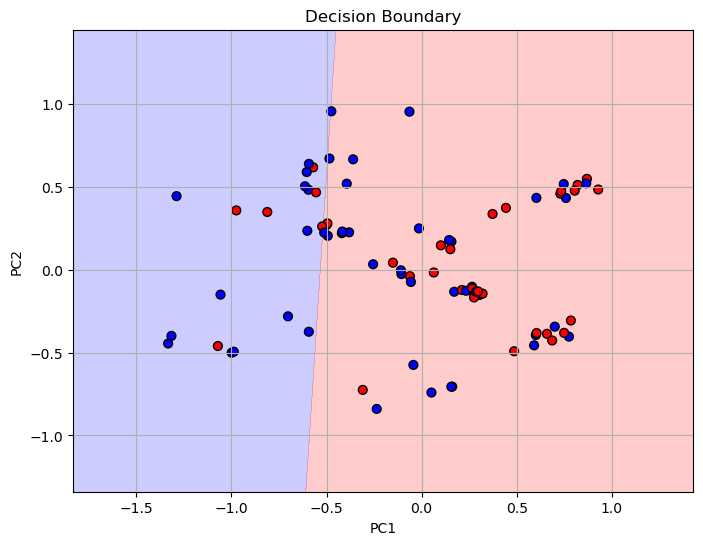

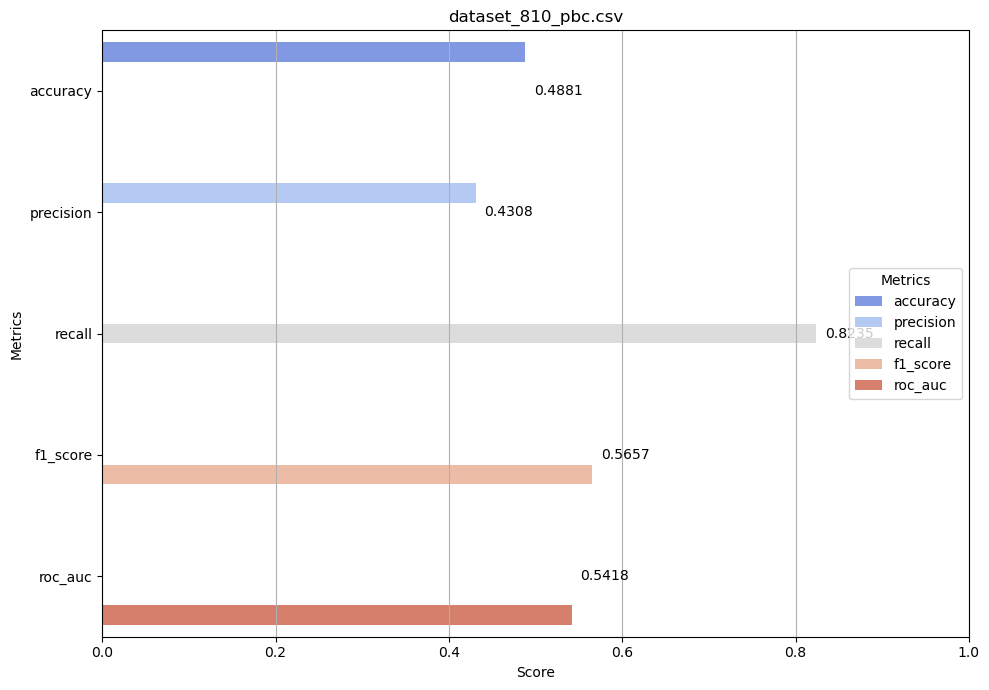

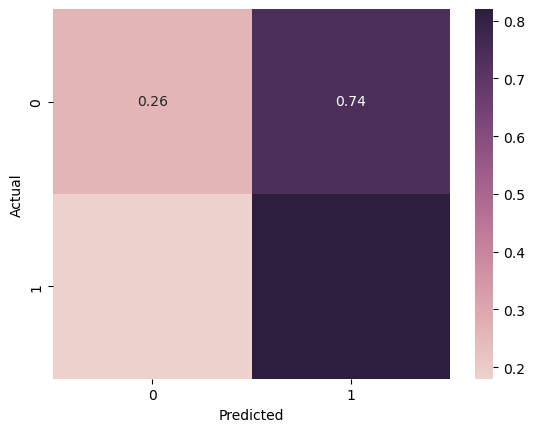

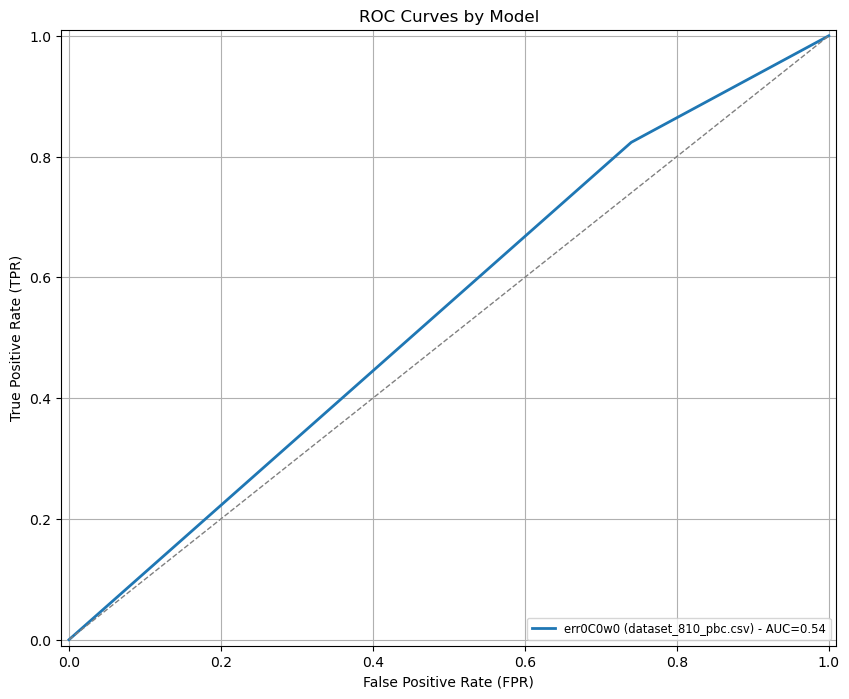

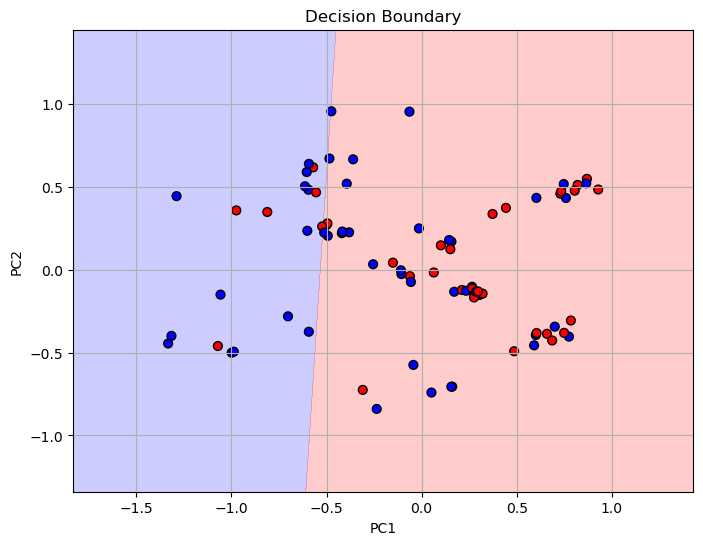

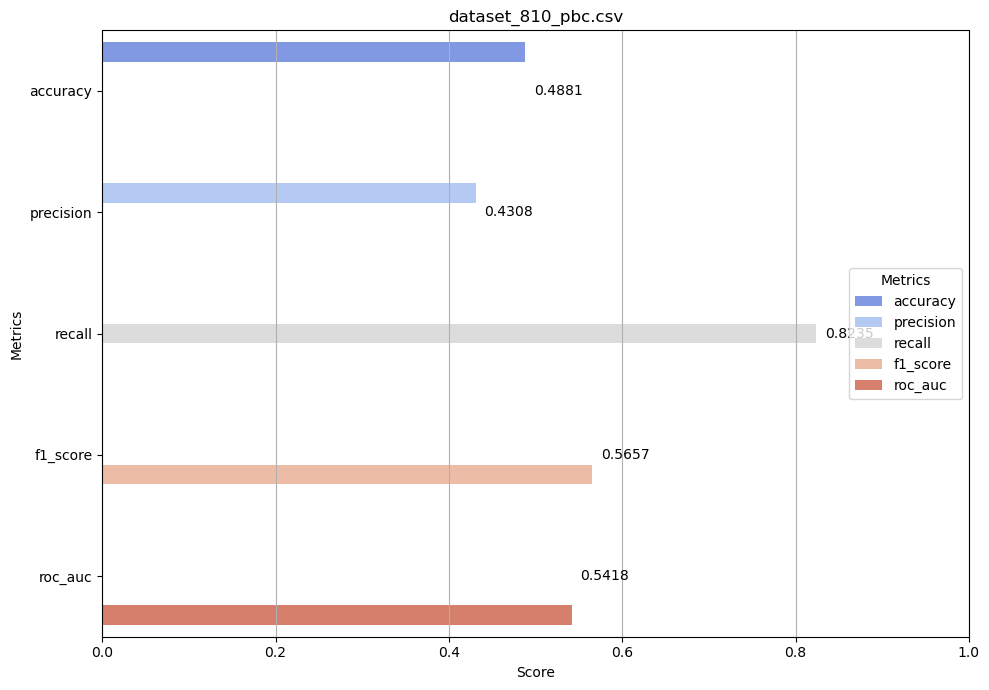

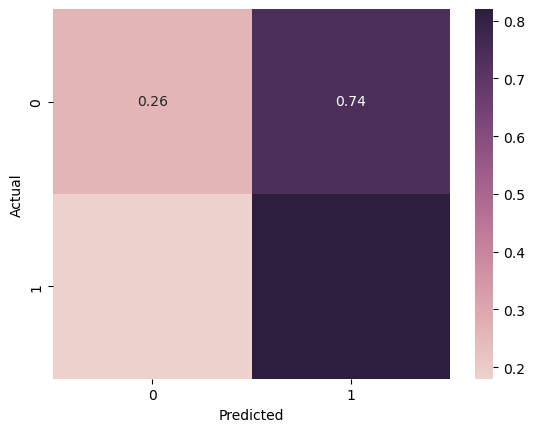

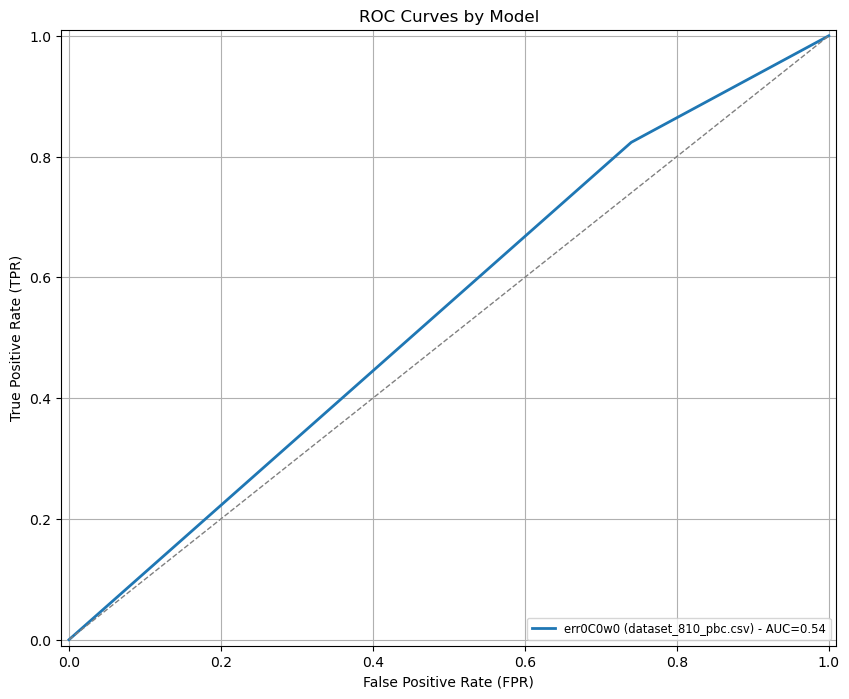

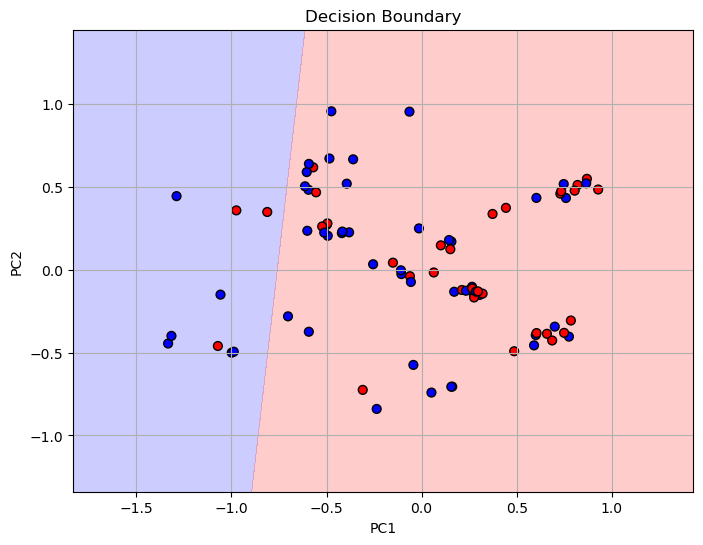

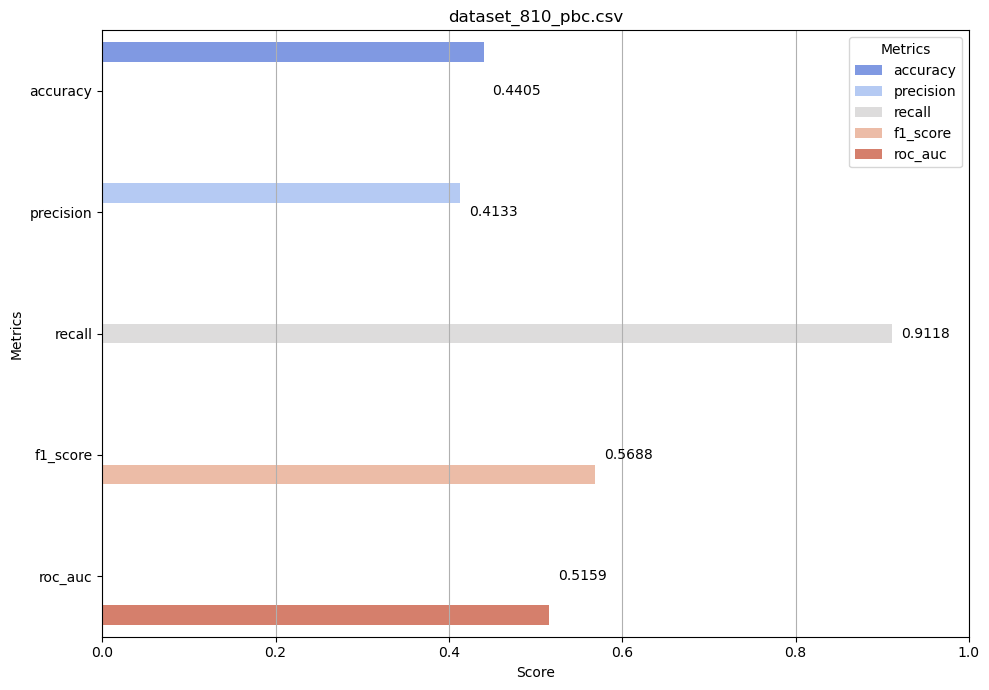

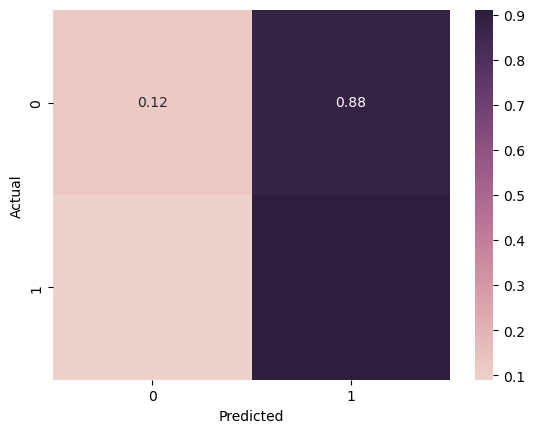

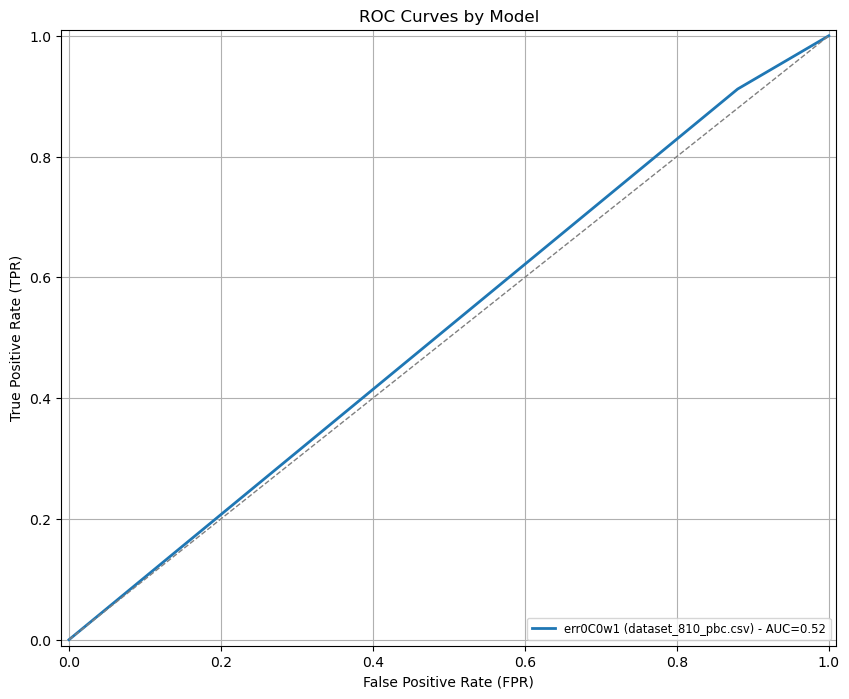

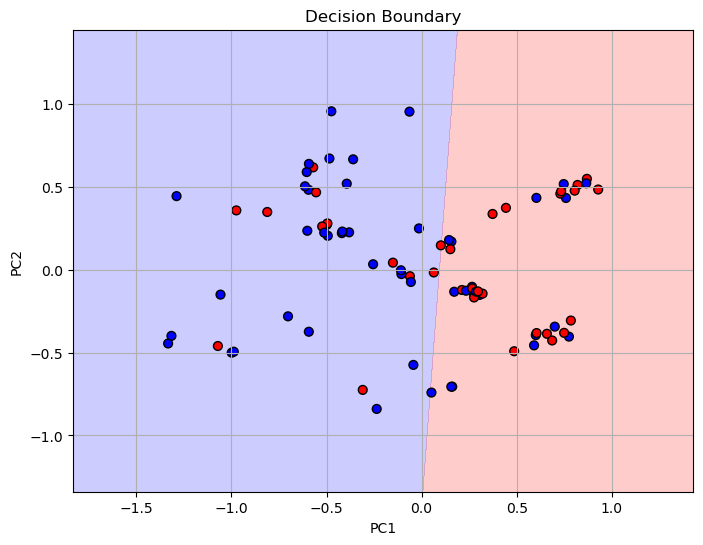

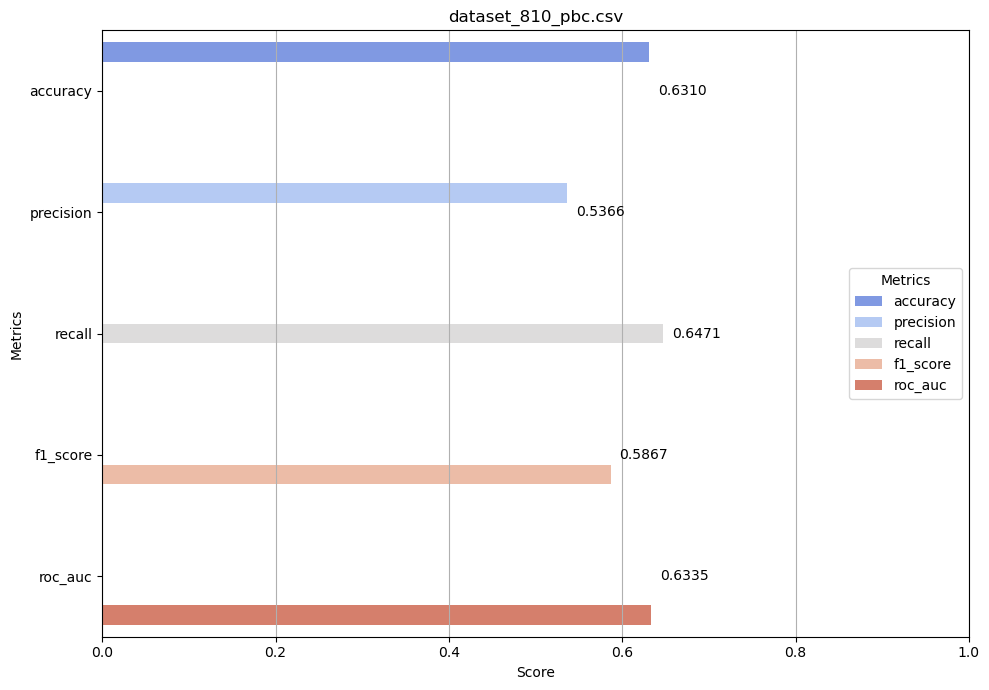

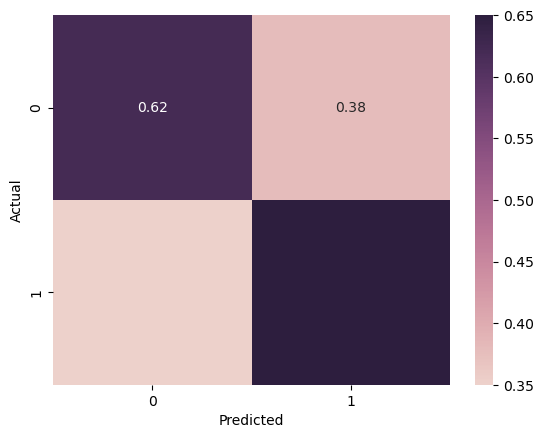

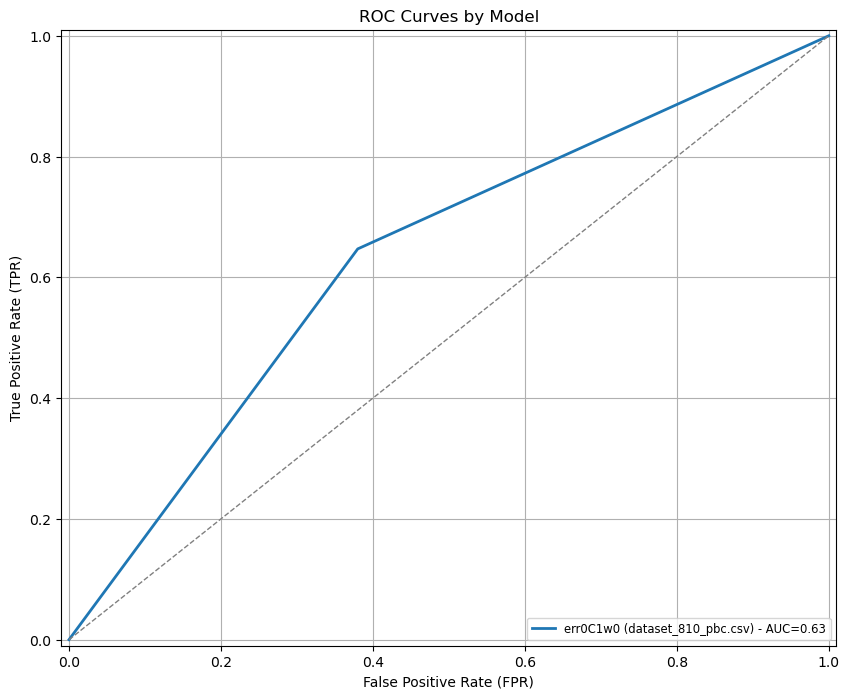

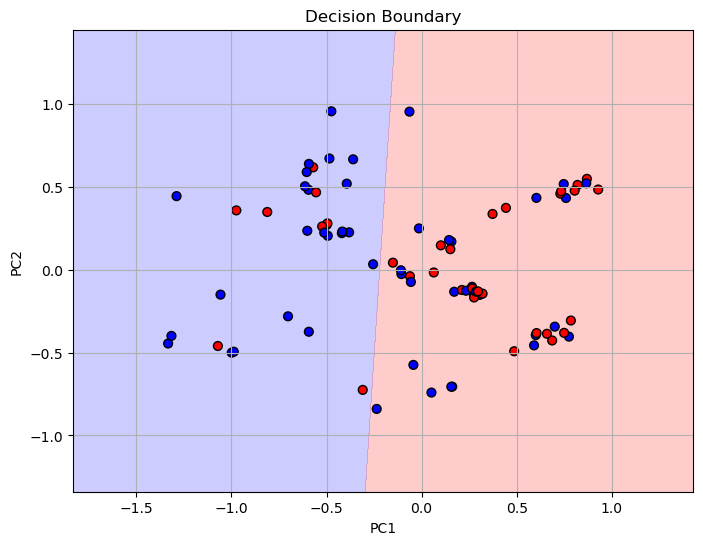

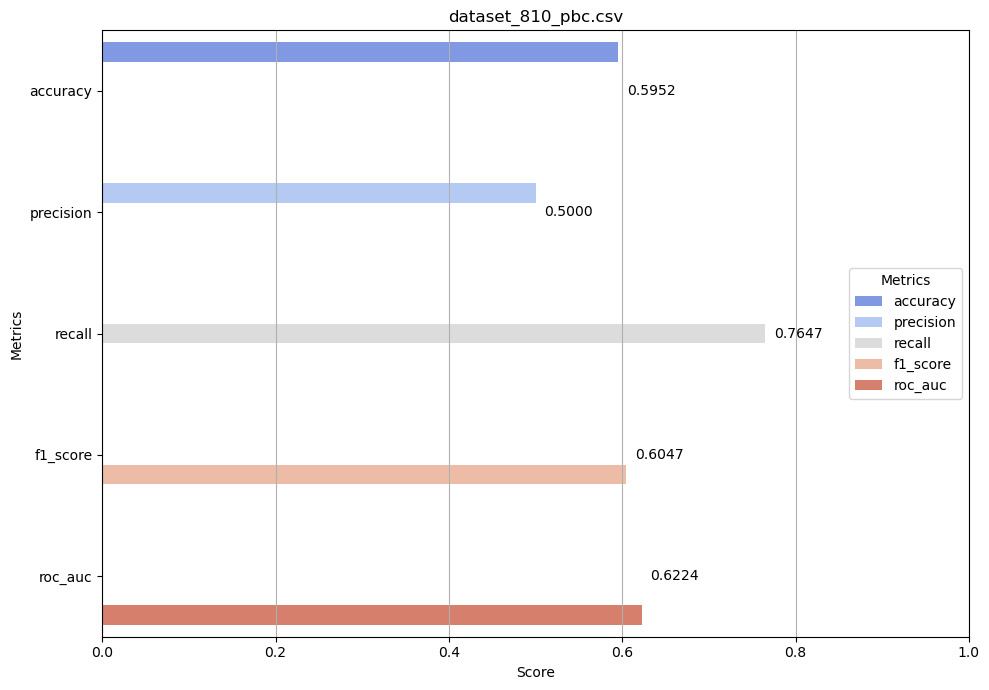

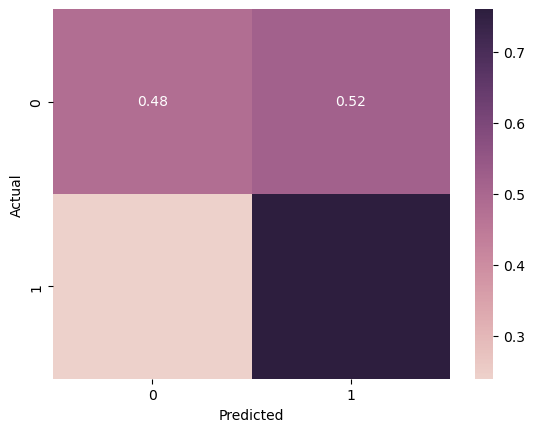

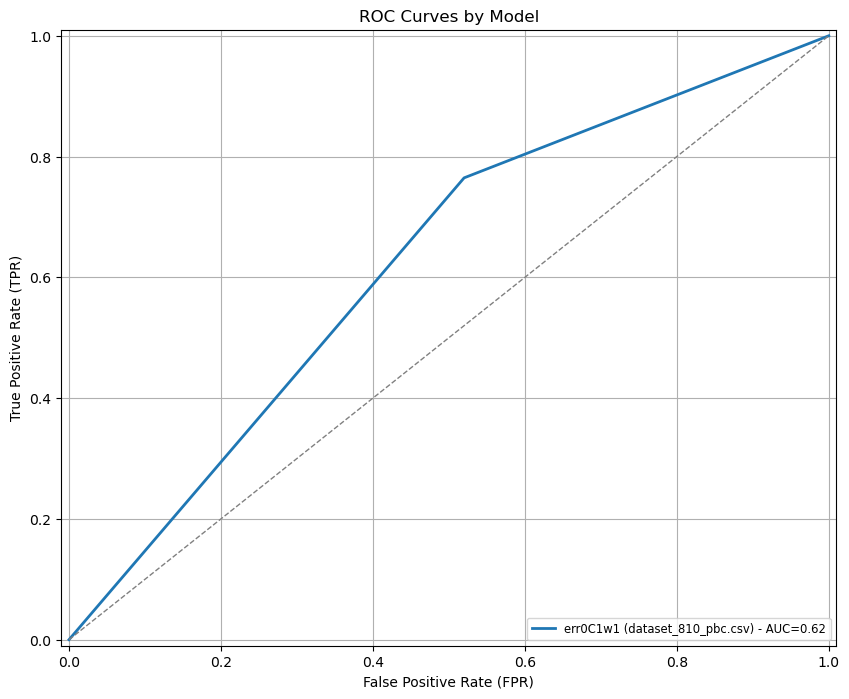

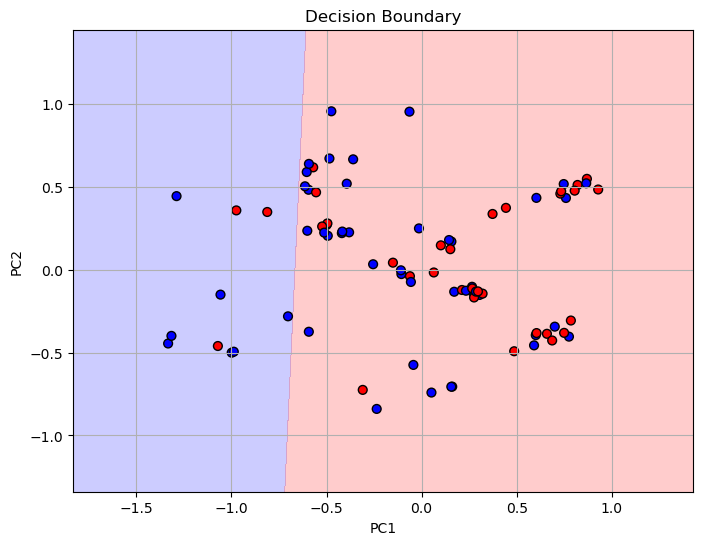

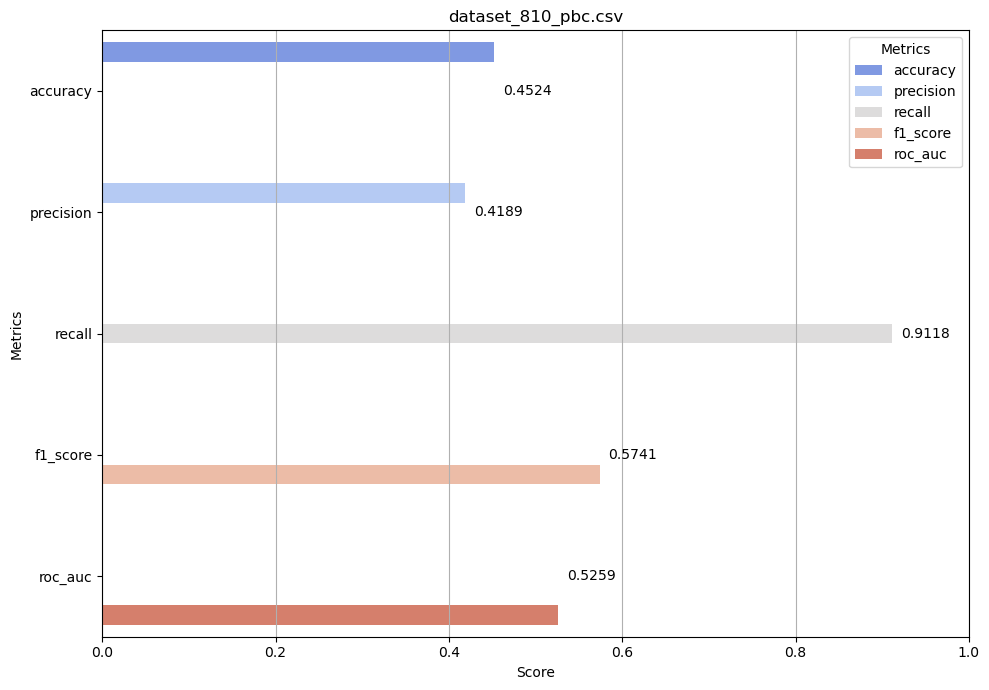

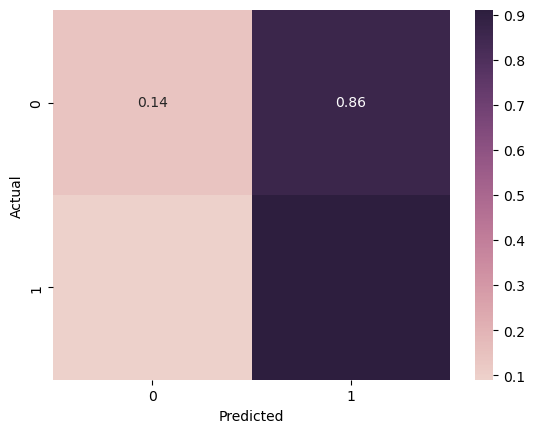

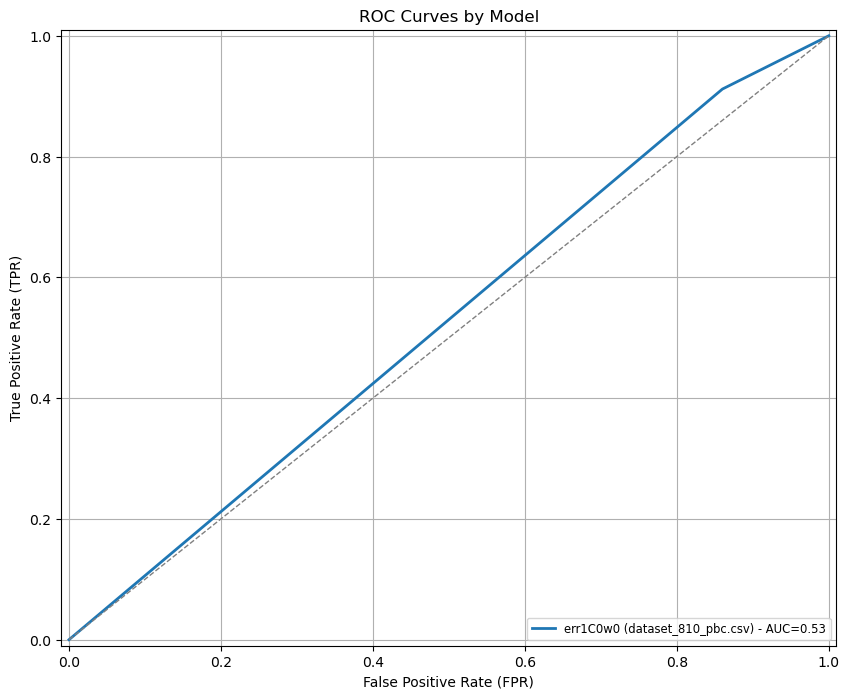

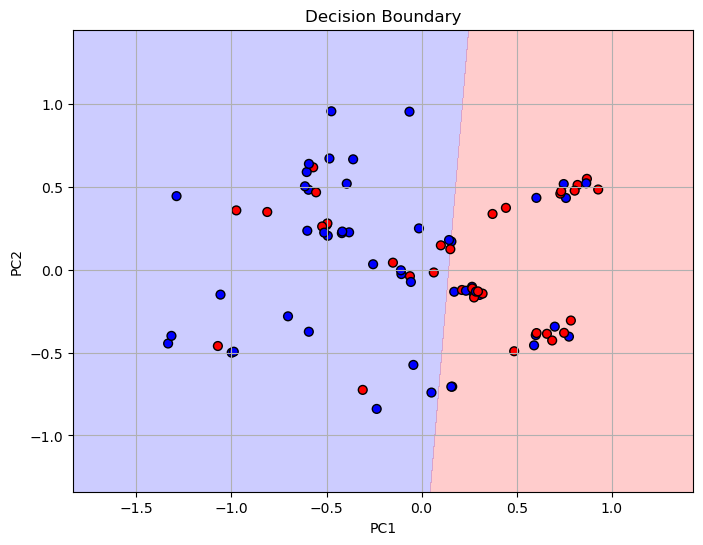

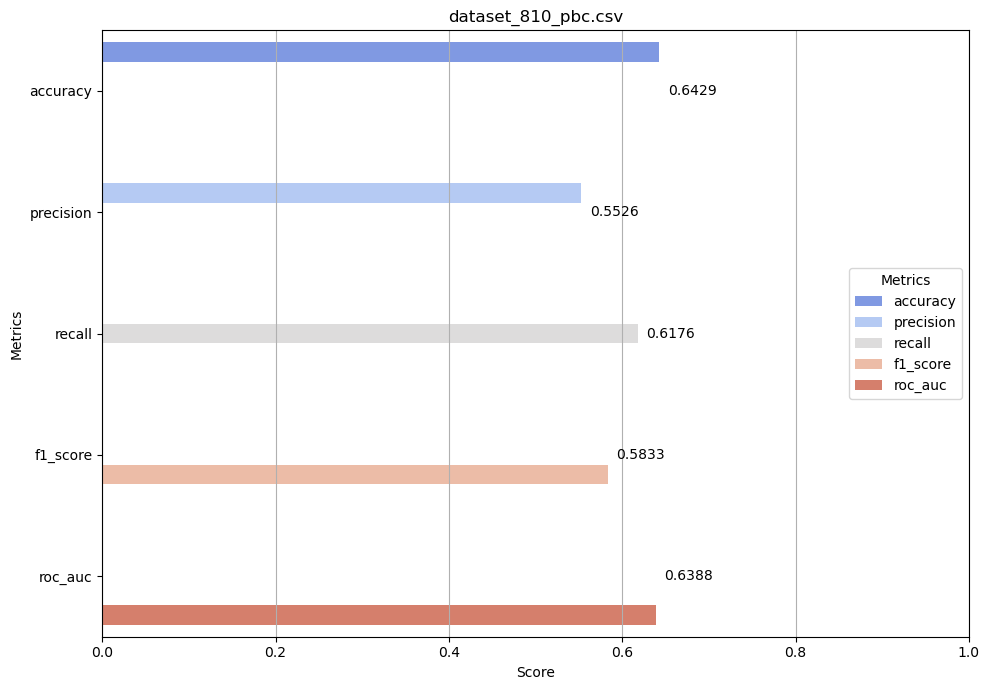

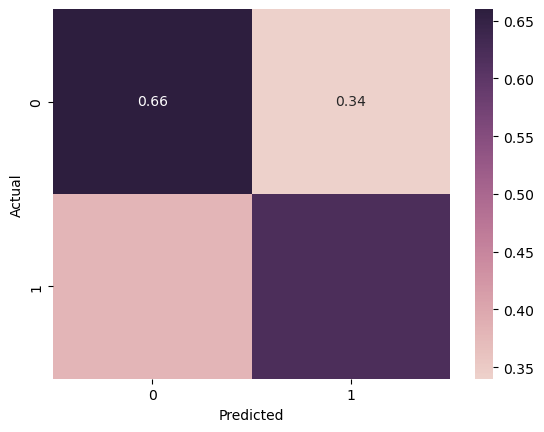

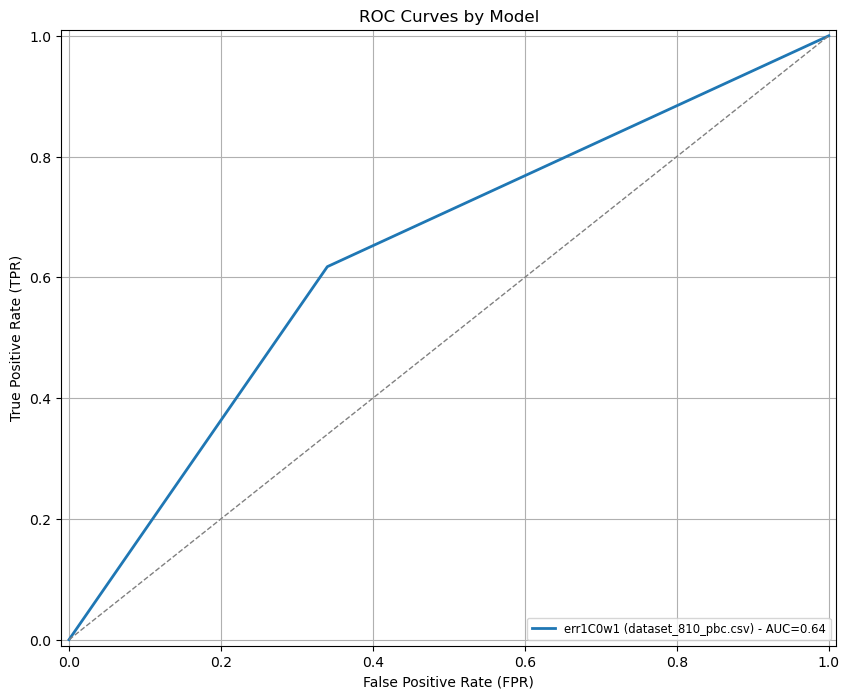

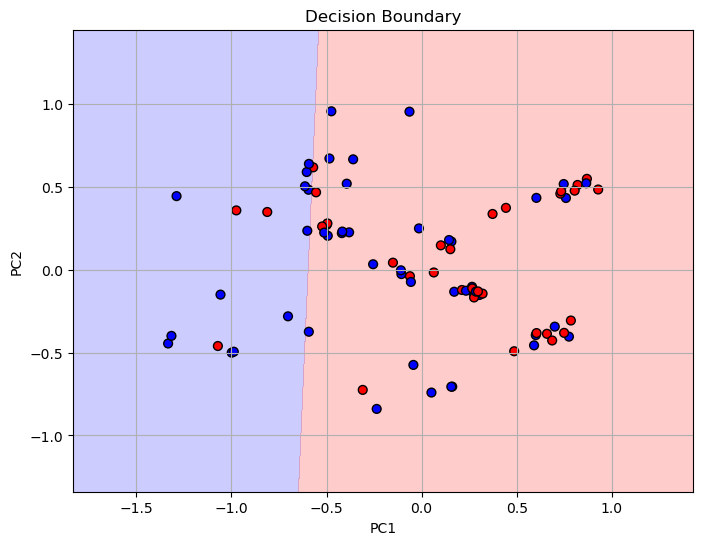

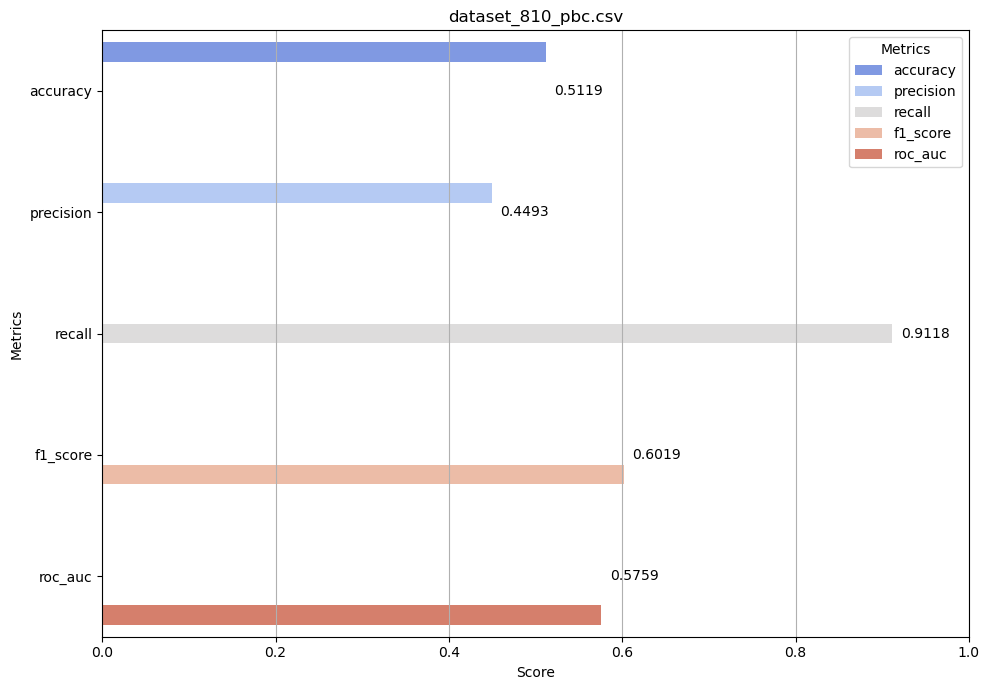

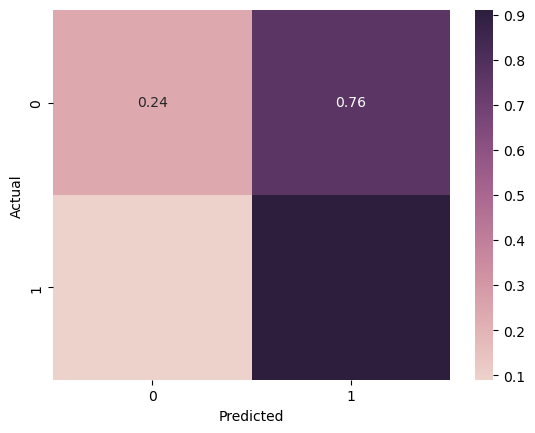

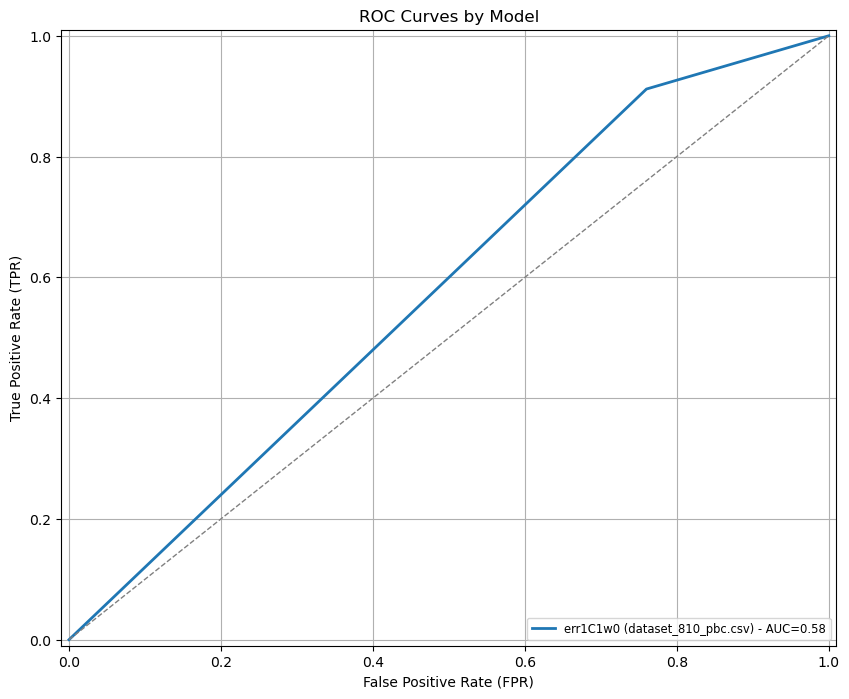

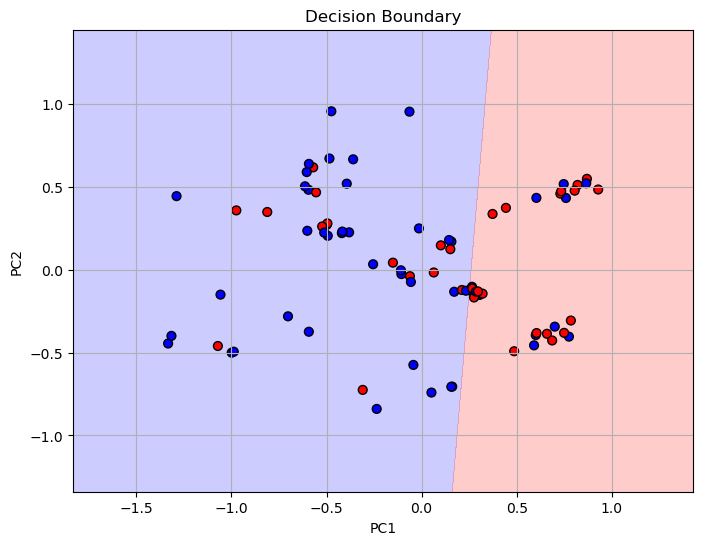

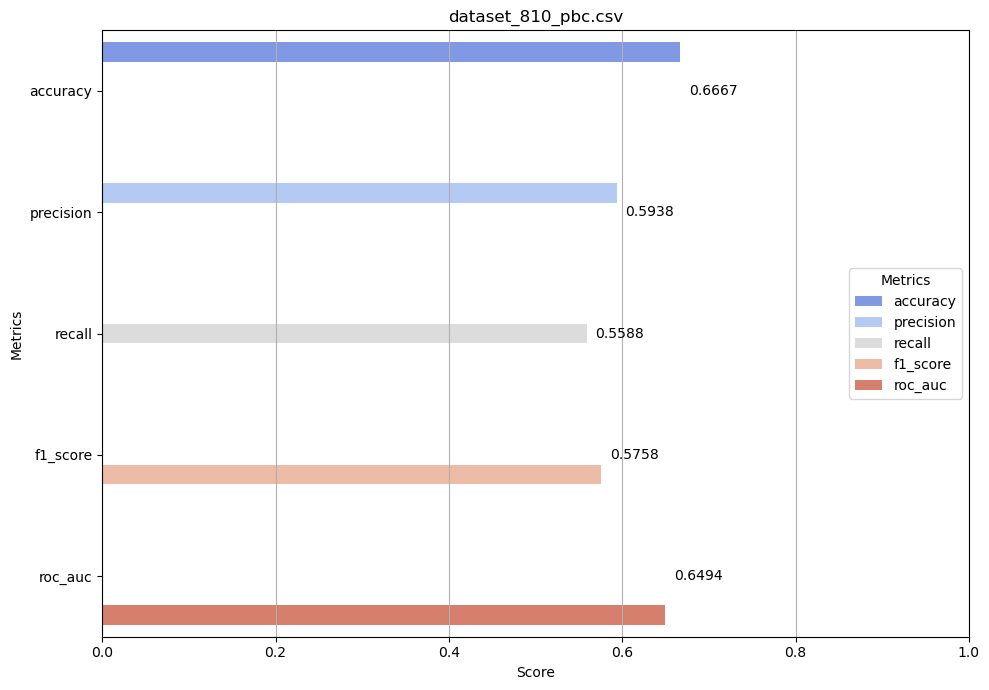

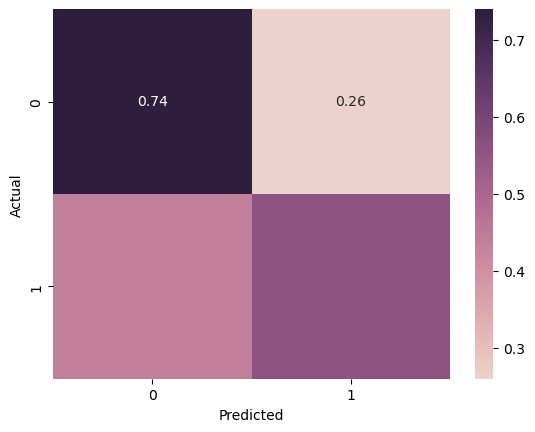

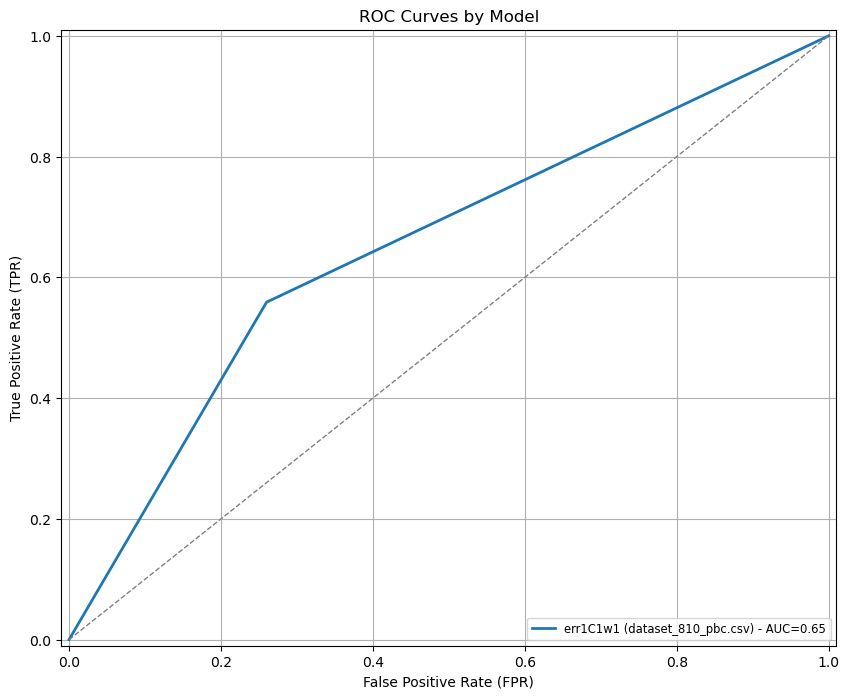

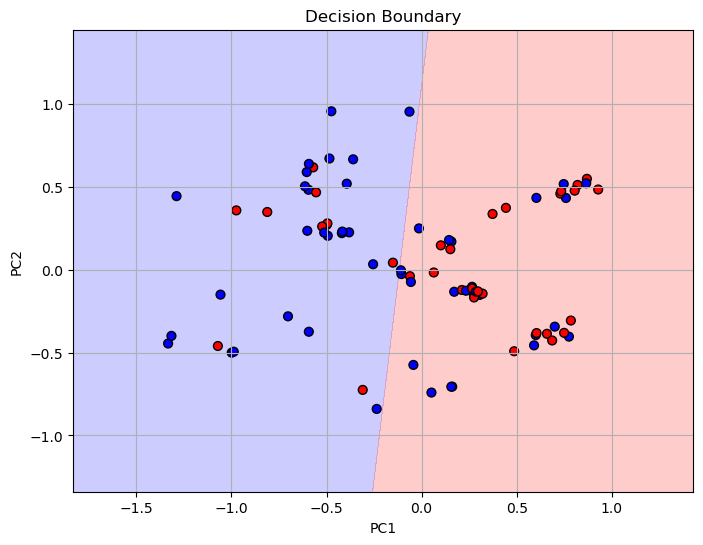

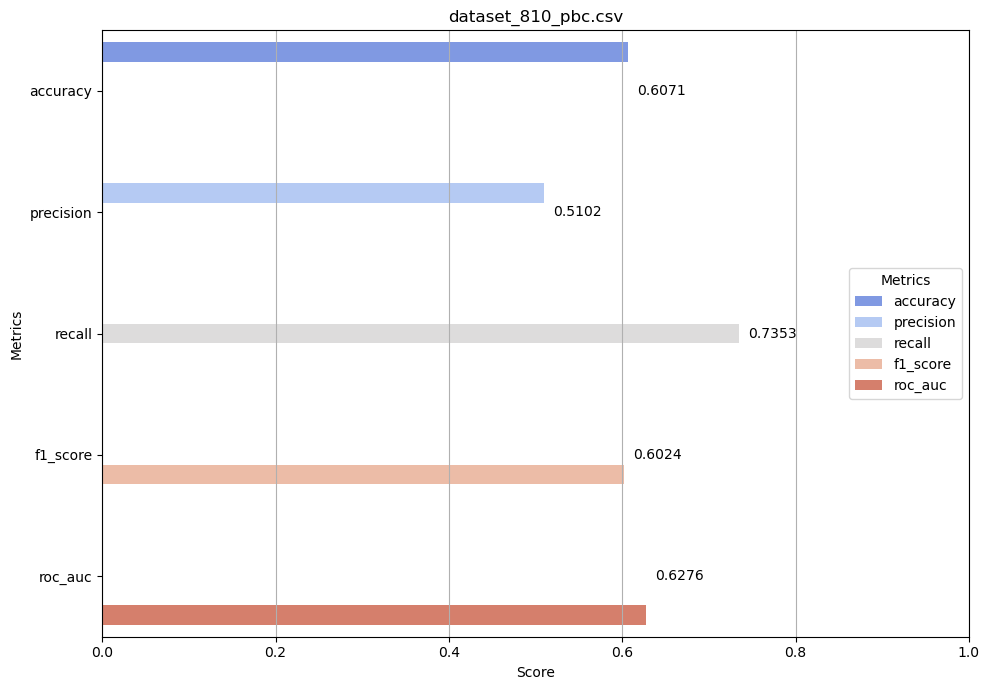

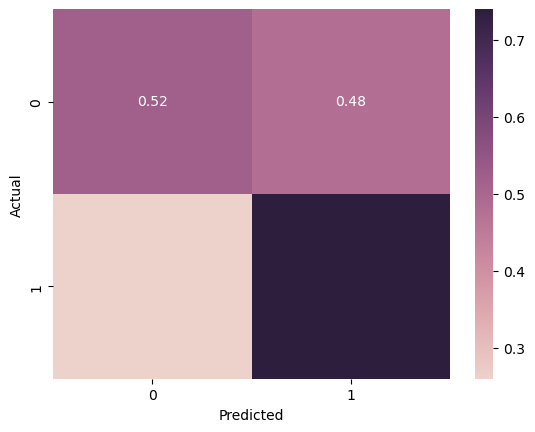

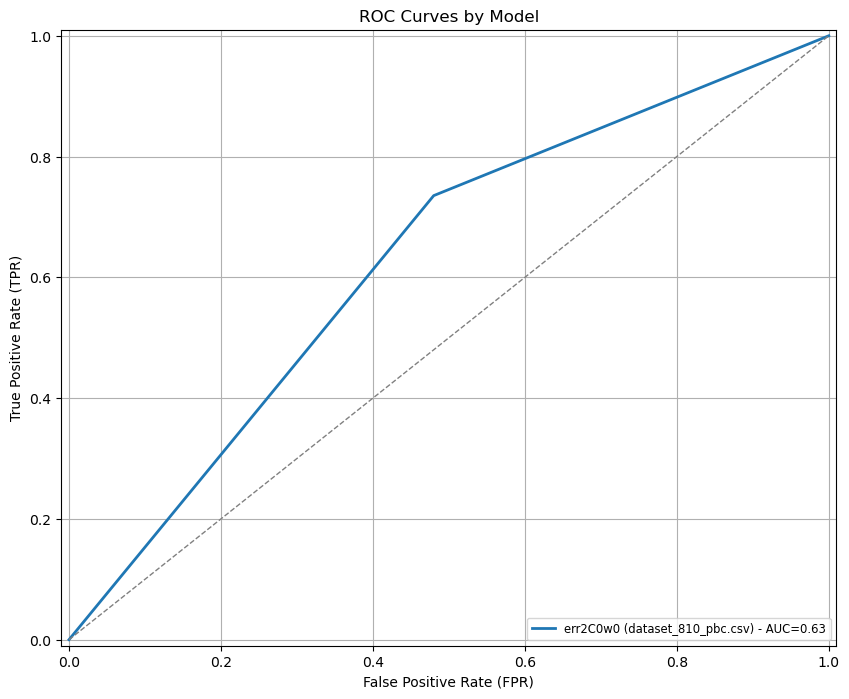

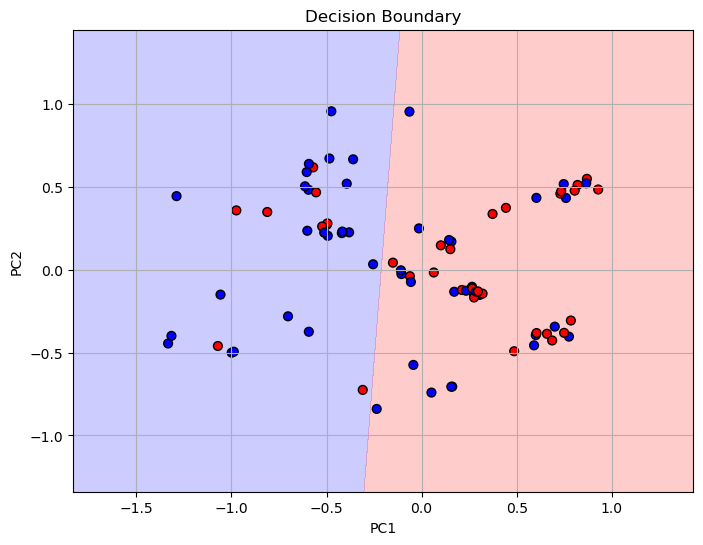

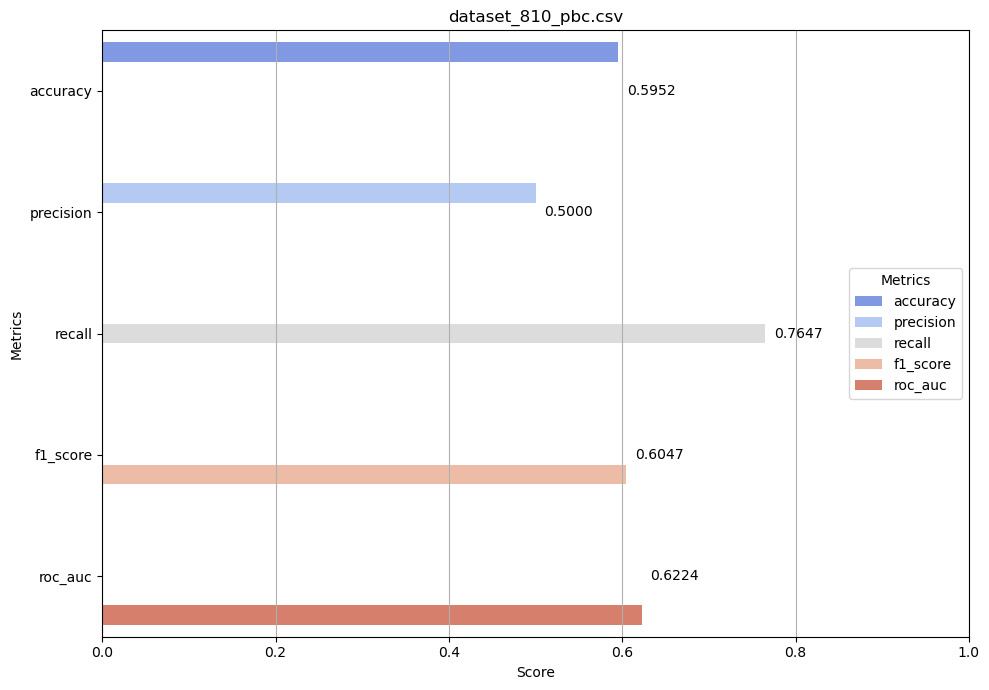

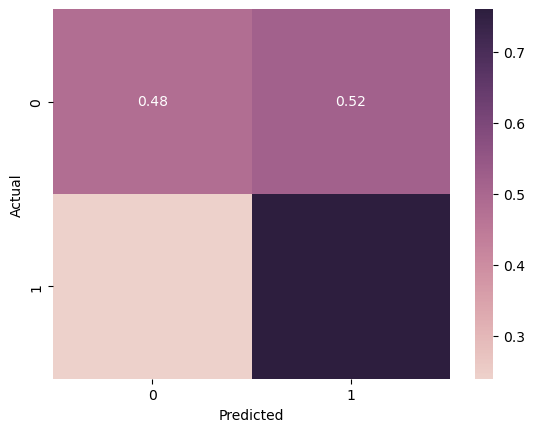

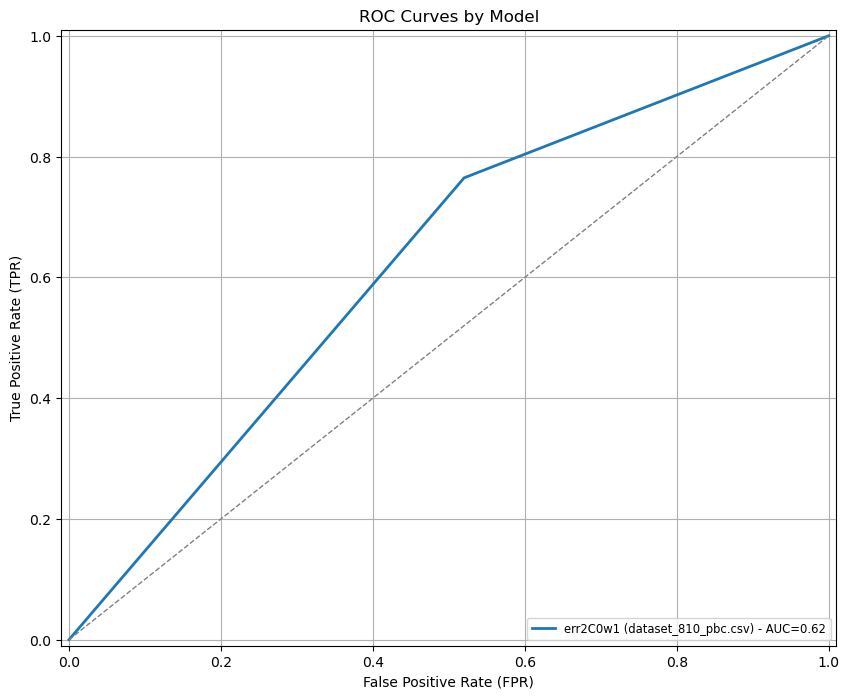

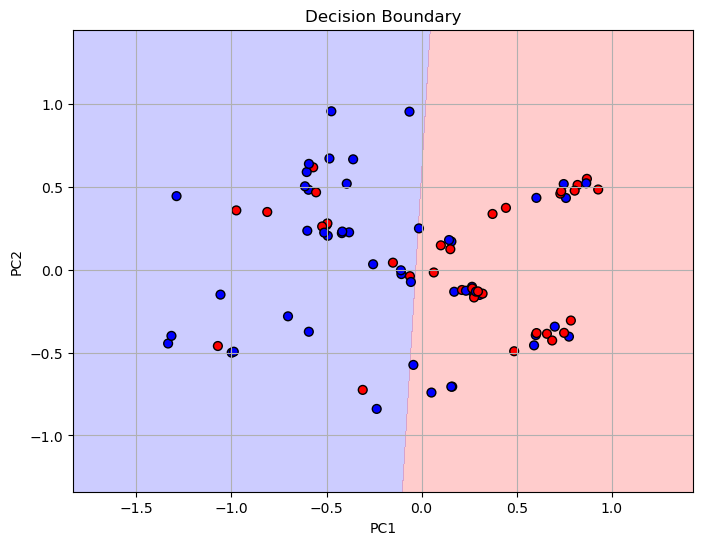

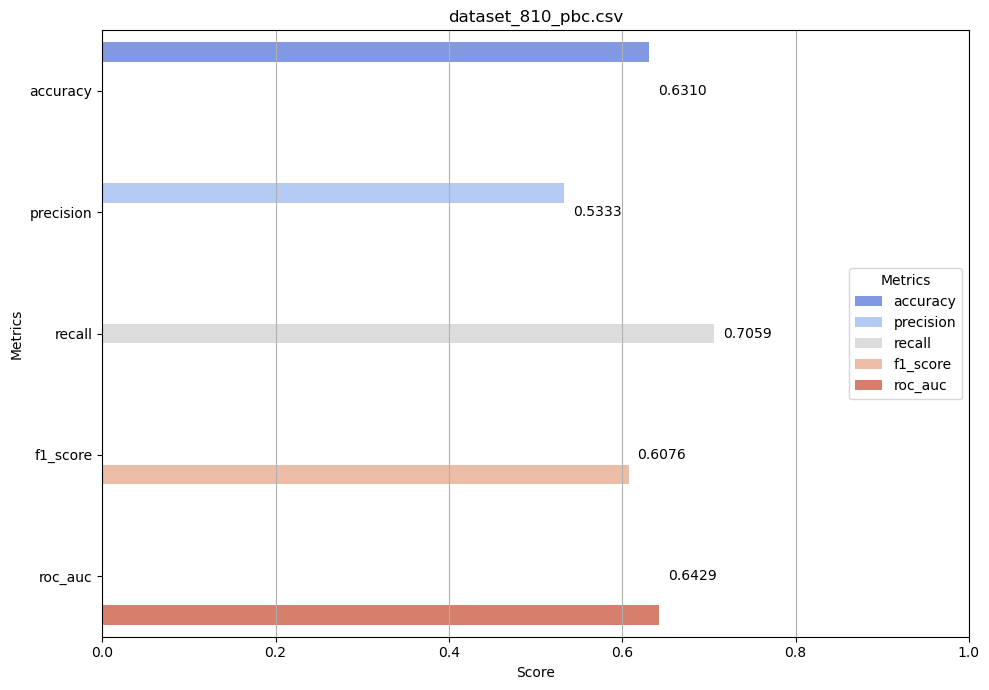

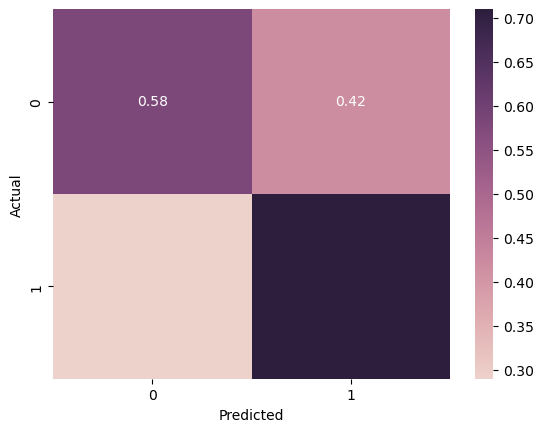

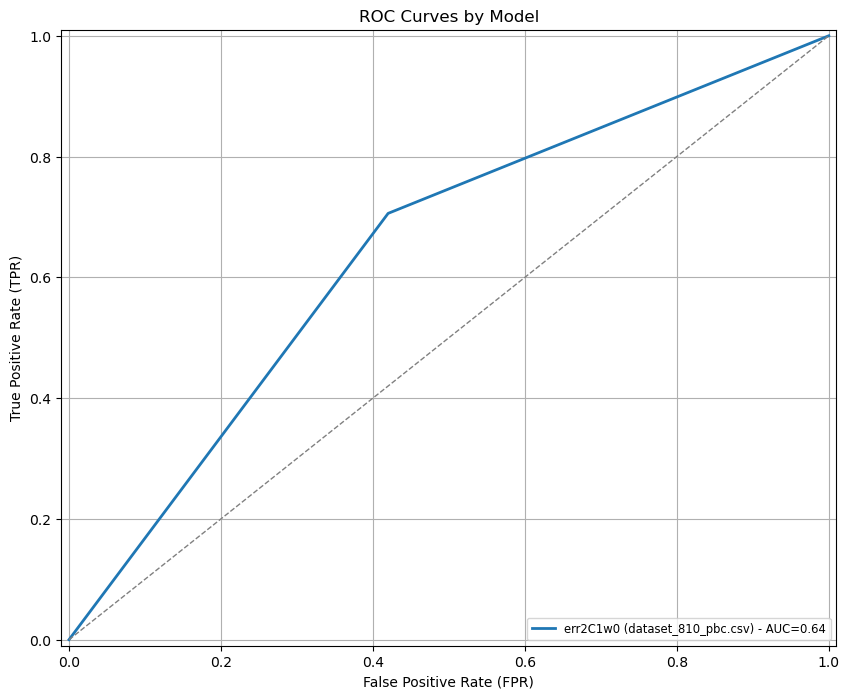

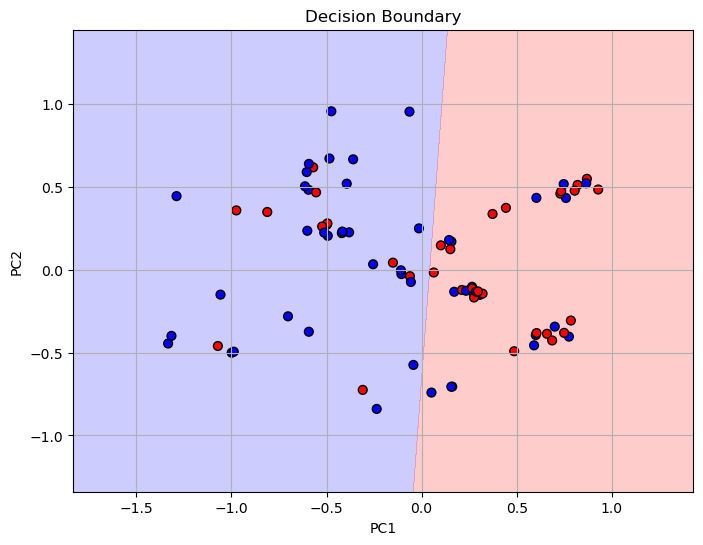

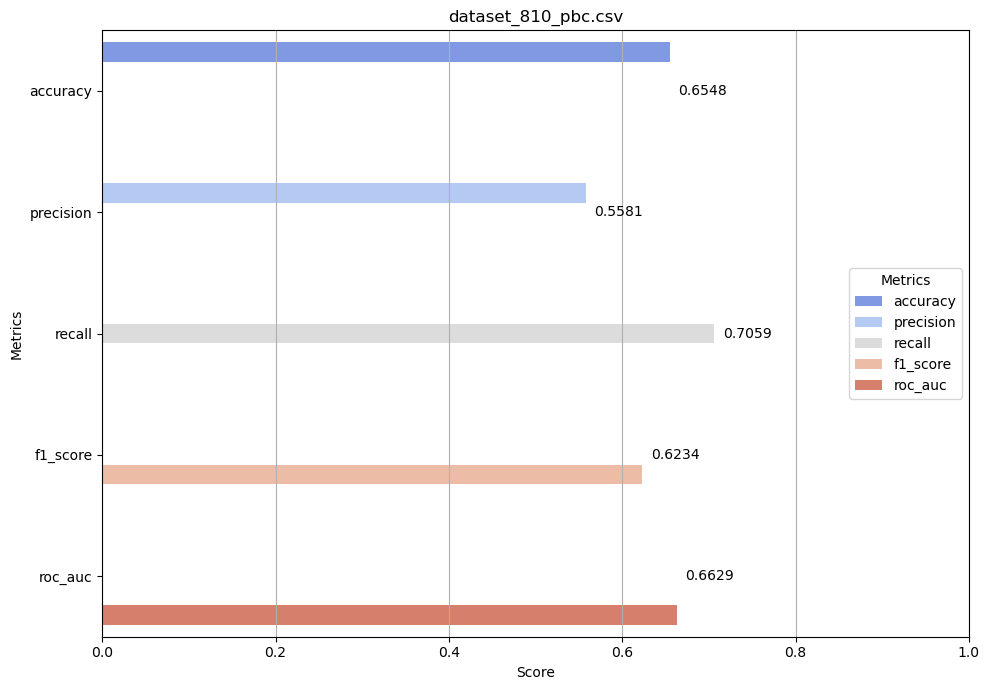

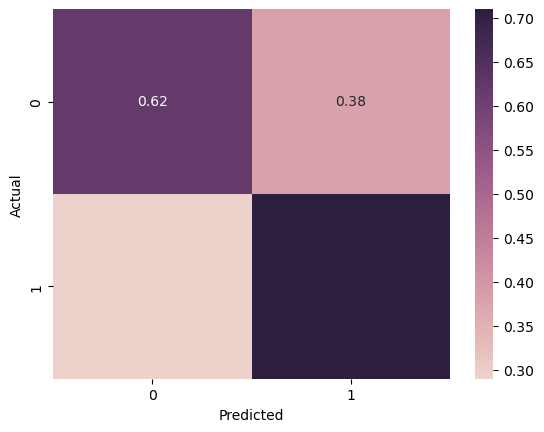

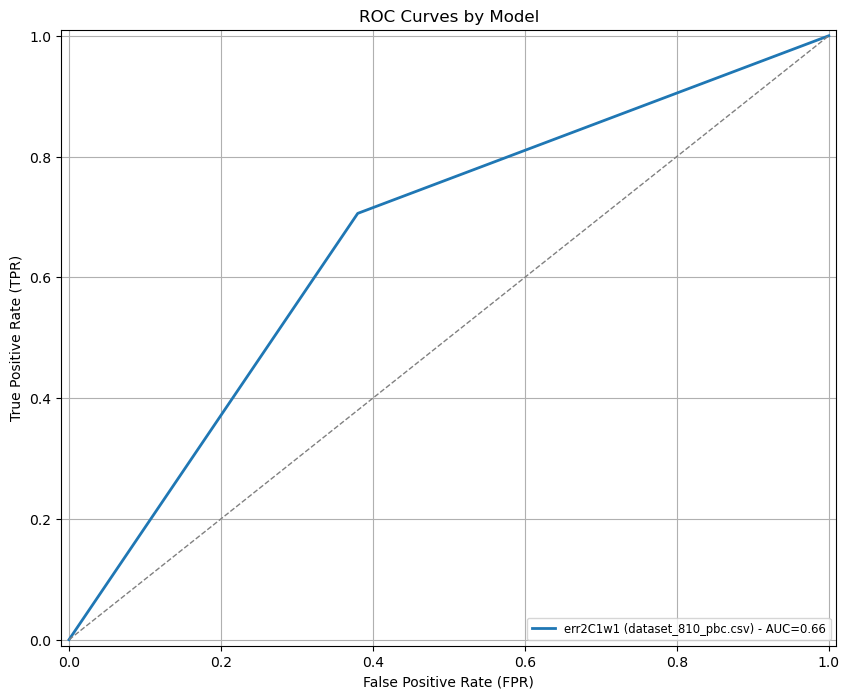

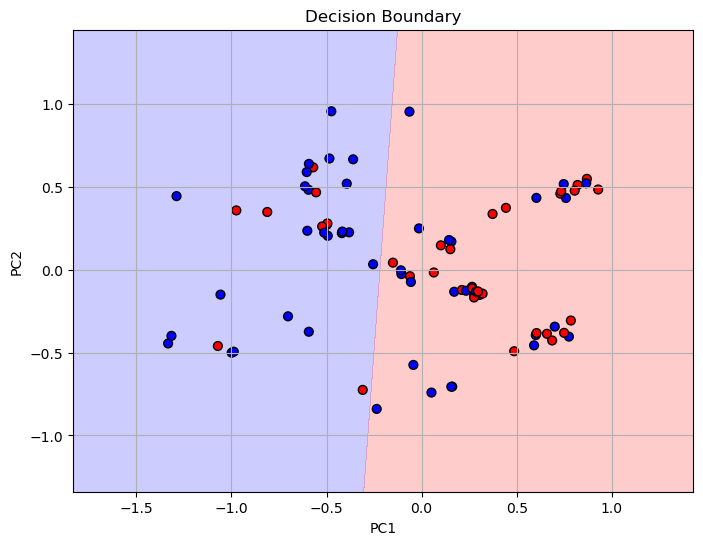

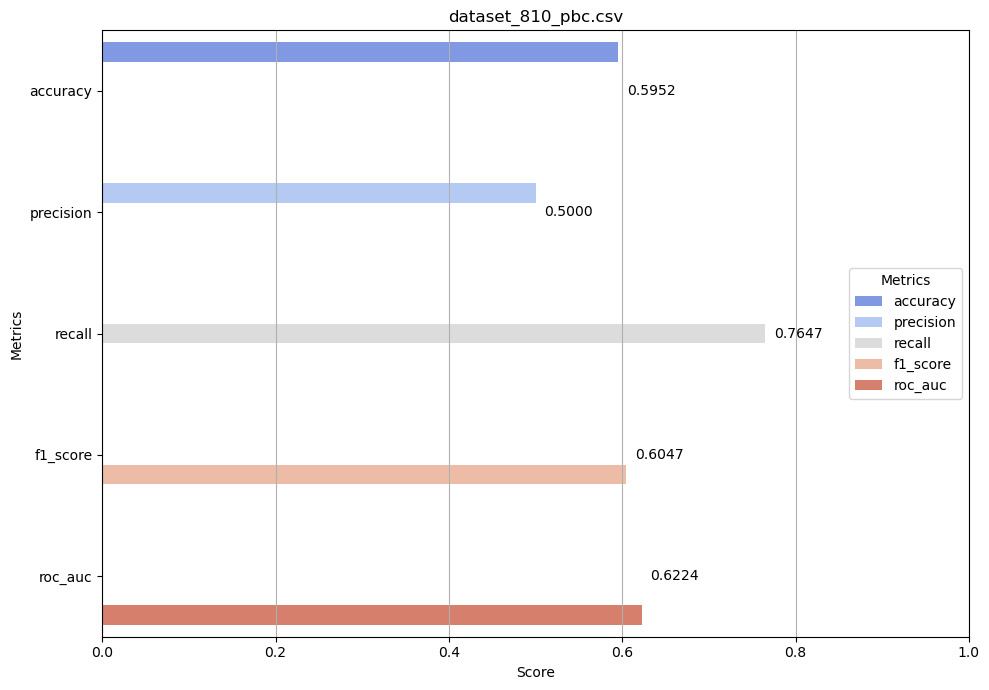

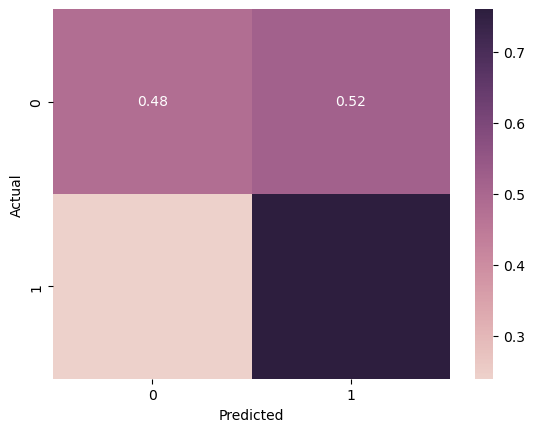

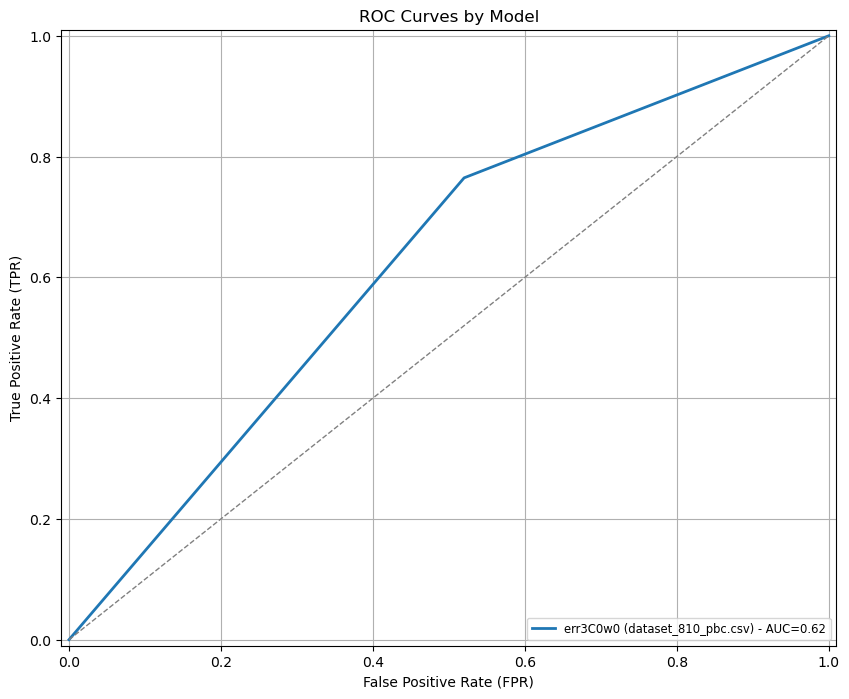

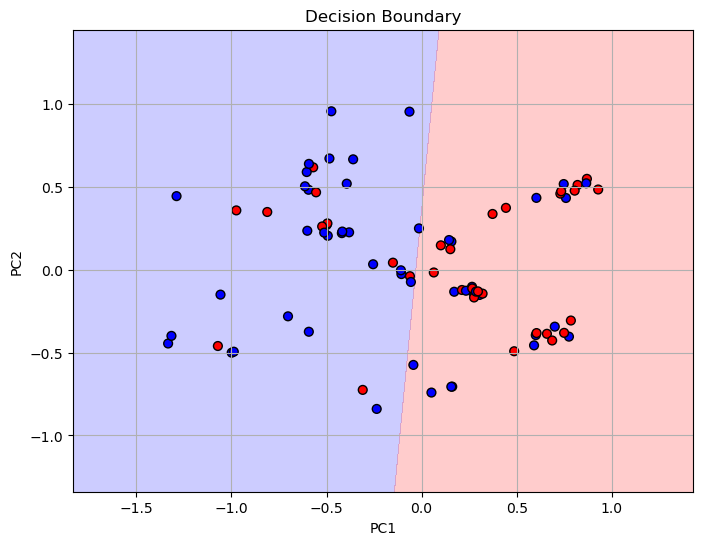

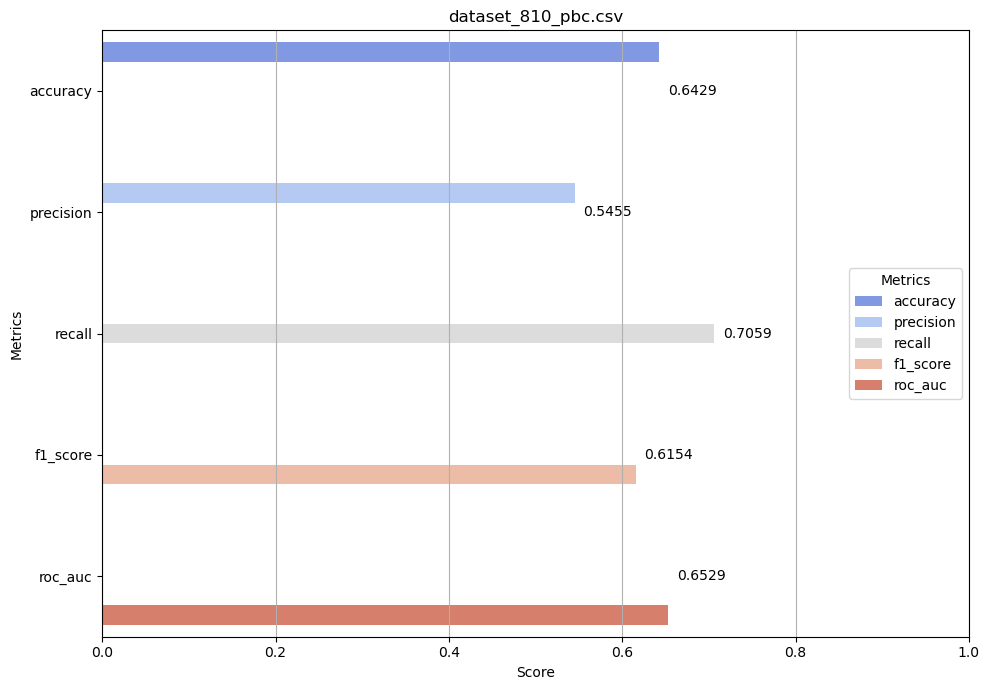

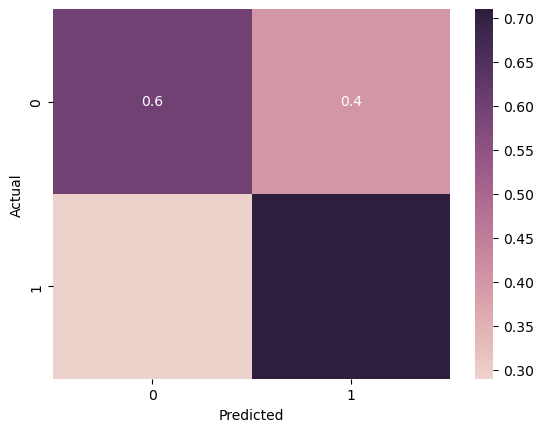

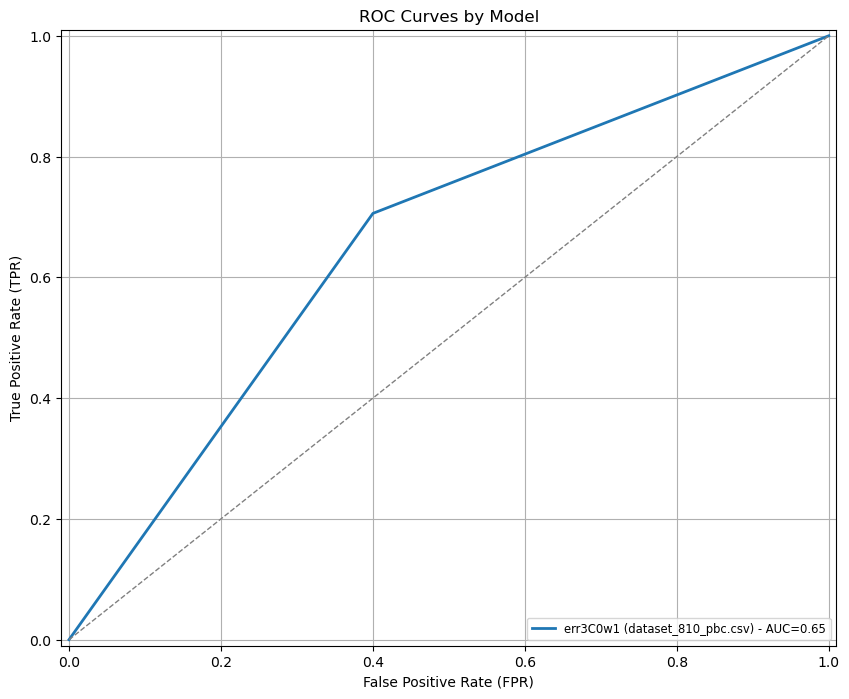

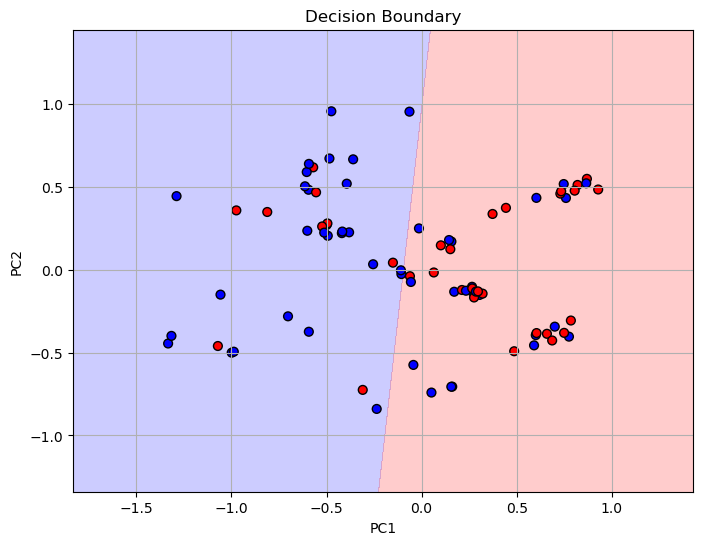

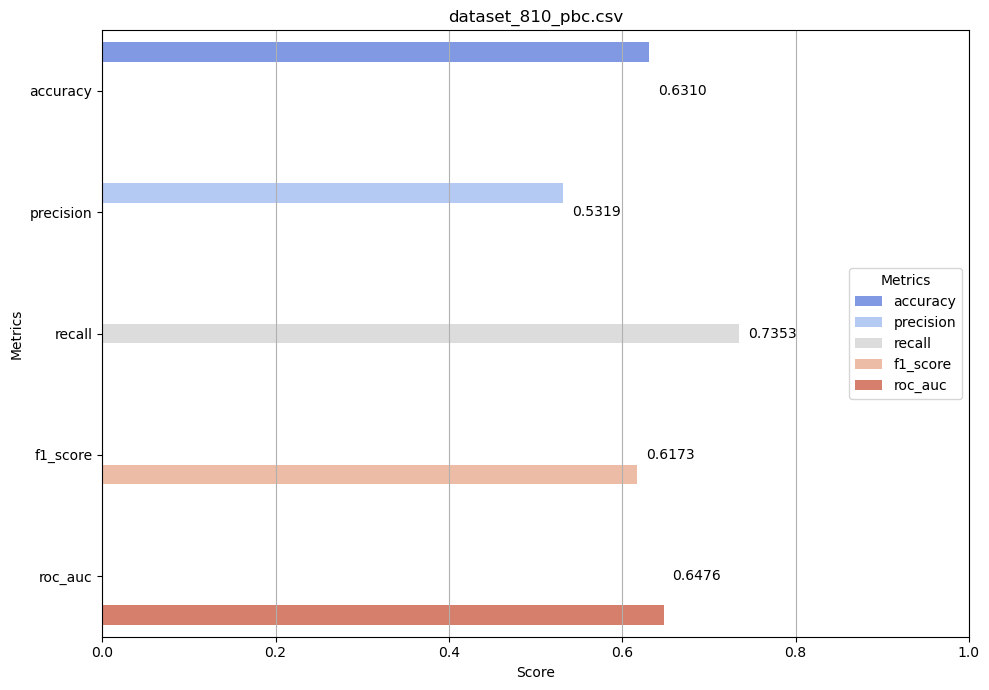

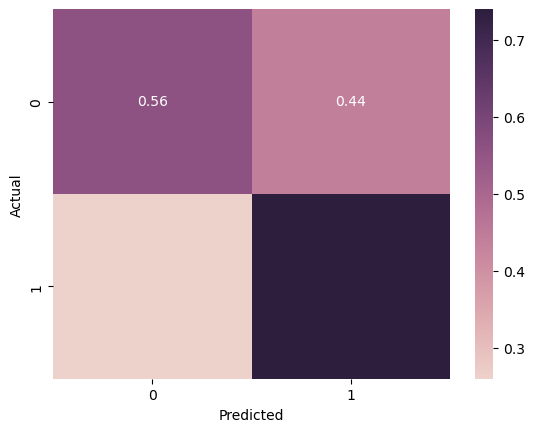

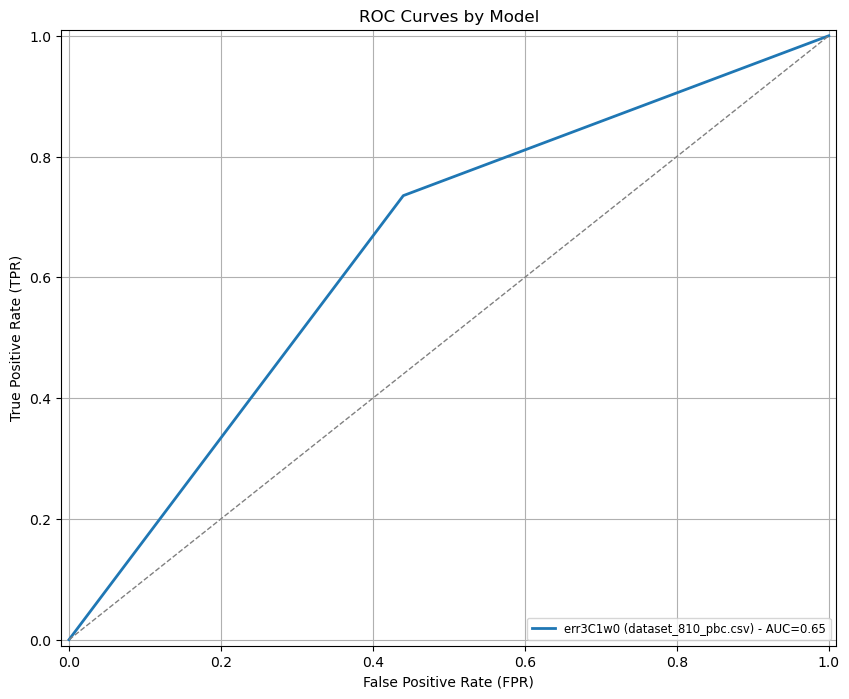

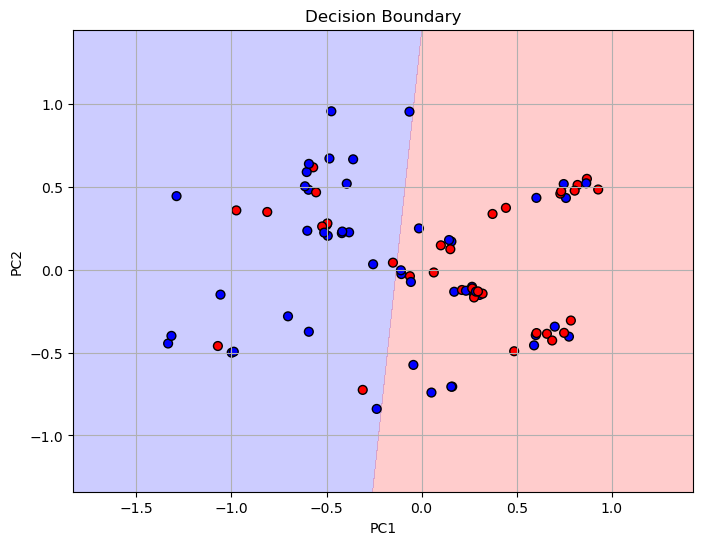

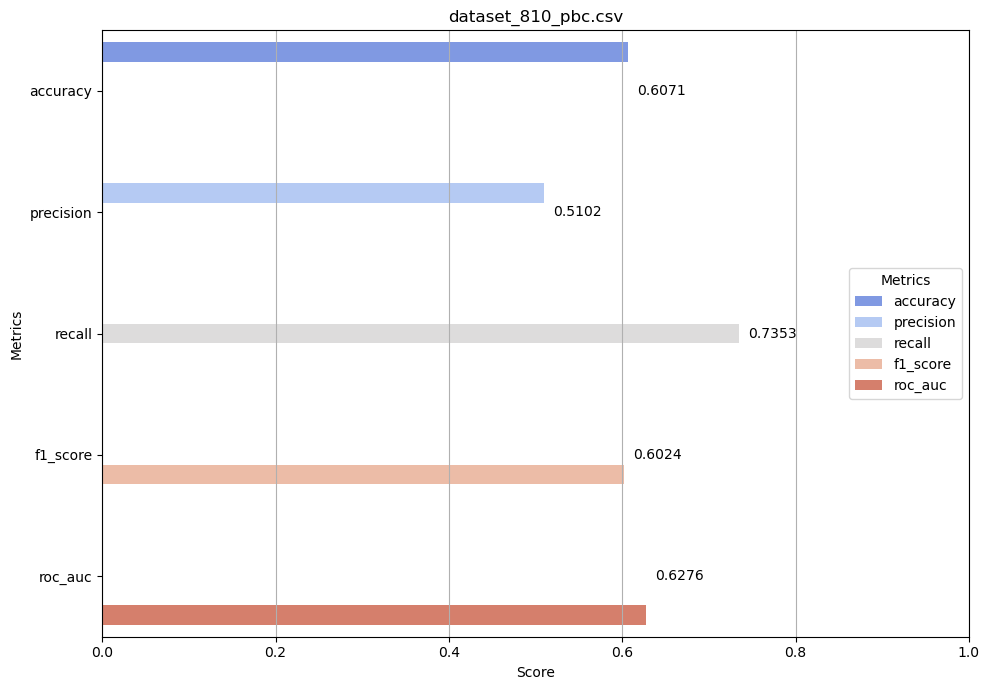

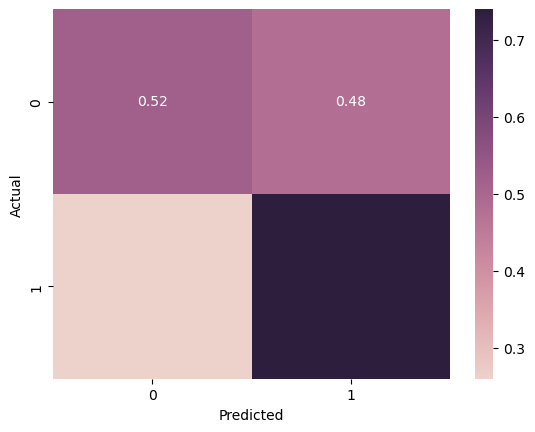

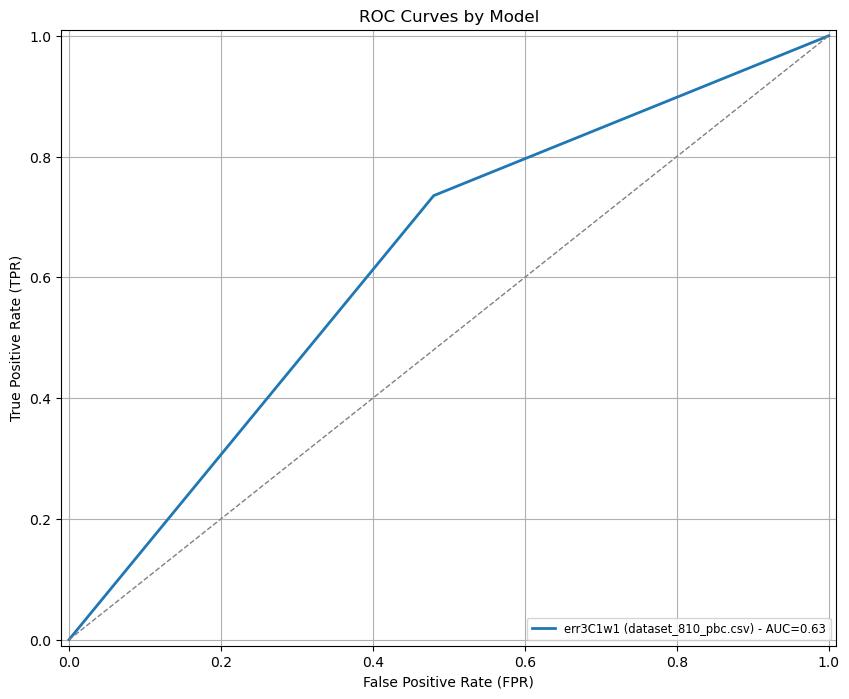

In [92]:
#Main function for terminal display
if __name__ == "__main__":
    folders = ["tests"]
    vizualize = "verbose"
    

    all_results = []
    config_labels = []
    for folder in folders:
        if vizualize == "no":
            print(f"\nEvaluating folder with standard SVM: {folder}")
        avg_results = evaluate_folder(folder, 0, 0, 0, 0, vizualize=vizualize)
        if avg_results:
            if vizualize == "no":
                print(f"Average Metrics for {folder}:")
                for metric, value in avg_results.items():
                    print(f"  {metric}: {value:.4f}")
        else:
            print(f"No valid datasets found in {folder}.")
        if vizualize == "no":
          print("\n---------------------------------------") #spacing for easier compairson

        for error in range(4):
            for c in range(2):
                for w in range(2):
                    if vizualize == "no":
                        print(f"\nEvaluating folder with modfied SVM with custom error {error},dynamic weights {w} and dynamic c {c}: {folder}")
                    avg_results = evaluate_folder(folder, 1, error=error, c=c, w=w, vizualize=vizualize)
                    if avg_results:
                        label = f"err={error},c={c},w={w}"
                        all_results.append(avg_results)
                        config_labels.append(label)
                        if vizualize == "no":
                            print(f"Average Metrics for {folder}:")
                            for metric, value in avg_results.items():
                                print(f"  {metric}: {value:.4f}")
                    else:
                        print(f"No valid datasets found in {folder}.")
                    if vizualize == "no":
                        print("\n---------------------------------------") #spacing for easier compairson
                        
    if vizualize == "simple":
        render(all_results, config_labels)
        plt.show()

In [ ]:
#Pipeline Functions output on terminal
def classification_from_dataframe(df, flag, n, c, w, vizualize, dataset_name=None):

    y = df.iloc[:, -1].copy()
    X = df.iloc[:, :-1].copy()
    X = pd.get_dummies(X, dummy_na=True) \
        .astype(float)
    X = X.fillna(X.mean())
    X = normalize_manual(X)


    if y.nunique() != 2:
        raise ValueError(f"Esperado problema binário. Valores encontrados em 'Class': {y.unique()}")

    y_mapped = pd.Series(np.nan, index=y.index)
    unique_classes = y.unique()
    y_mapped[y == unique_classes[0]] = -1
    y_mapped[y == unique_classes[1]] = 1

    if y_mapped.isnull().any():
        raise ValueError("Não foi possível mapear os rótulos para {-1, 1}.")

    y = y_mapped.astype(int)

    X_2d = pca_manual(X, n_components=2)
    X = X_2d
    y = y.to_numpy()
    X_train, X_test, y_train, y_test = train_test_split_manual(X, y, test_size=0.2, random_state=42)

    kernel = Linear()
    class_weight = {1: 1.0, -1: 1.0}
    C = 1.0
    if flag == 0:
        model = SVM(C=C, class_weight=class_weight, kernel=kernel, max_iter=500)
    elif flag == 1: 
        if w == 1:class_weight = compute_class_weight(y_train)
        if c == 1:C = dynamic_C_based_on_variance(X_train, base_C=1.0)
        model = New_SVM(C=C, class_weight=class_weight, kernel=kernel, max_iter=500, error_flag=n)

    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    metrics = compute_metrics(y_test, predictions, pos_label=1)
    confusion_matrix_a = confusion_matrix(y_true=y_test, y_pred=predictions) 
    rocdict = {
        'model': f'err{n}C{c}w{w}',
        'dataset': dataset_name if dataset_name else "unknown",
        'y_test': y_test,
        'y_score': predictions
          }
    if vizualize == "verbose":
        plot_decision_boundary(model, X_test, y_test, title="Decision Boundary")
        grafic(metrics, dataset_name)
        heatmappers(confusion_matrix_a)
        roc_plot(roc_dict)

    return metrics

def evaluate_folder(folder_path, flag, error, c, w, vizualize):
    results = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path)
            try:
                metrics = classification_from_dataframe(
                    df, flag, n=error, c=c, w=w, dataset_name=filename, vizualize=vizualize)
                results.append(metrics)
               # print(f"Processed {filename}")
            except Exception as e:
                print(f"Failed on {filename}: {e}")

    if not results:
        return None

    avg_metrics = {key: np.mean([res[key] for res in results]) for key in results[0]}
    return avg_metrics

In [227]:
# Função principal: salva tudo em um único CSV
if __name__ == "__main__":
    folder = "tests"
    all_results = []  # Lista para guardar todos os DataFrames
    for error in range(4):
        for c in range(2):
            for w in range(2):
                print(f"Running config error={error}, c={c}, w={w}")
                df_results = evaluate_folder_csv(folder, error, c, w)
                if df_results is not None:
                    all_results.append(df_results)
    # Concatenar tudo em um único DataFrame
    if all_results:
        final_df = pd.concat(all_results, ignore_index=True)
        # Ordena as colunas para garantir formato compatível com ANOVA e mixedlm
        col_order = ['accuracy', 'precision', 'recall', 'f1_score','roc_auc', 'dataset', 'error', 'dynamic_C', 'dynamic_weight']
        final_df = final_df[[c for c in col_order if c in final_df.columns]]
        # Salva o CSV no padrão correto
        outpath = f"{folder}_all_results.csv"
        final_df.to_csv(outpath, index=False)
        print(f"Todos os resultados salvos em {outpath}")
    else:
        print("Nenhum resultado foi gerado.")

Running config error=0, c=0, w=0
Processed dataset_164_molecular-biology_promoters.csv
Processed dataset_810_pbc.csv
Running config error=0, c=0, w=1
Processed dataset_164_molecular-biology_promoters.csv
Processed dataset_810_pbc.csv
Running config error=0, c=1, w=0
Processed dataset_164_molecular-biology_promoters.csv
Processed dataset_810_pbc.csv
Running config error=0, c=1, w=1
Processed dataset_164_molecular-biology_promoters.csv
Processed dataset_810_pbc.csv
Running config error=1, c=0, w=0
Processed dataset_164_molecular-biology_promoters.csv
Processed dataset_810_pbc.csv
Running config error=1, c=0, w=1
Processed dataset_164_molecular-biology_promoters.csv
Processed dataset_810_pbc.csv
Running config error=1, c=1, w=0
Processed dataset_164_molecular-biology_promoters.csv
Processed dataset_810_pbc.csv
Running config error=1, c=1, w=1
Processed dataset_164_molecular-biology_promoters.csv
Processed dataset_810_pbc.csv
Running config error=2, c=0, w=0
Processed dataset_164_molecular

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x000001AA504E3DA0>


Resumo estatístico das métricas:
        accuracy  precision     recall   f1_score    roc_auc
count  32.000000  32.000000  32.000000  32.000000  32.000000
mean    0.688312   0.667192   0.746630   0.690837   0.698627
std     0.107682   0.162211   0.108305   0.106037   0.091676
min     0.440476   0.413333   0.558824   0.565657   0.515882
25%     0.625000   0.529990   0.666667   0.593833   0.632059
50%     0.696970   0.654018   0.735294   0.675325   0.689804
75%     0.772727   0.818182   0.833333   0.772575   0.783333
max     0.863636   0.888889   1.000000   0.880000   0.858333

Médias das métricas por combinação de estratégias:
                                accuracy  precision    recall  f1_score   roc_auc
error dynamic_C dynamic_weight                                                   
0     0         0               0.653139   0.608242  0.870098  0.705905  0.675049
                1               0.583874   0.606667  0.789216  0.648040  0.624608
      1         0               0.7018

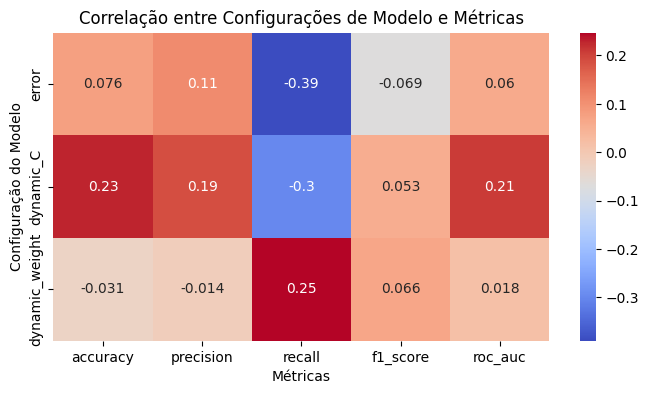


--- ANOVA para accuracy ---
                                  sum_sq    df         F    PR(>F)
C(dynamic_C)                    0.018660   1.0  1.095759  0.308334
C(dynamic_weight)               0.000337   1.0  0.019809  0.889553
C(error)                        0.006710   3.0  0.131354  0.940230
C(dynamic_C):C(dynamic_weight)  0.000159   1.0  0.009363  0.923929
C(dynamic_C):C(error)           0.008543   3.0  0.167232  0.917150
C(dynamic_weight):C(error)      0.001497   3.0  0.029306  0.993013
Residual                        0.323550  19.0       NaN       NaN
------------------------------------------------------------
Interpretação: p-value < 0.05 indica que o fator/interação tem efeito estatisticamente significativo sobre a métrica considerada (ao nível de 5%).

--- ANOVA para precision ---
                                  sum_sq    df         F    PR(>F)
C(dynamic_C)                    0.029177   1.0  0.731017  0.403207
C(dynamic_weight)               0.000162   1.0  0.004057  0.949

In [232]:
#Statistical analysis
# ---------------------------
# 1. Carregando os Dados
# ---------------------------
# Lê o arquivo CSV com os resultados de todas as execuções
df = pd.read_csv("tests_all_results.csv")

# Exibe todas as colunas, linhas longas, etc., para facilitar leitura no terminal
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)

# Garante tipos corretos para os fatores (estratégias codificadas como 0/1 ou 0/1/2/3)
df['error'] = df['error'].astype(int)
df['dynamic_C'] = df['dynamic_C'].astype(int)
df['dynamic_weight'] = df['dynamic_weight'].astype(int)
# NÃO transforme roc_auc em int! Métrica contínua.
df['roc_auc'] = df['roc_auc'].astype(float)

# ---------------------------
# 2. Estatísticas Descritivas Básicas
# ---------------------------
print("Resumo estatístico das métricas:")
print(df[['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']].describe())

# ---------------------------
# 3. Agrupamento por Estratégias e Médias
# ---------------------------
print("\nMédias das métricas por combinação de estratégias:")
print(
    df.groupby(['error', 'dynamic_C', 'dynamic_weight'])[['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']].mean()
)

# ---------------------------
# 4. Modelo Linear Misto: Mixed Linear Model (efeito aleatório do dataset)
# ---------------------------
print("\nModelo Linear Misto: efeito aleatório do dataset")
model = mixedlm(
    "roc_auc ~ C(error) + C(dynamic_C) + C(dynamic_weight)", 
    data=df, 
    groups="dataset"
)
result = model.fit()
print(result.summary())

# ---------------------------
# 5. Heatmap de Correlação: Configurações vs. Métricas
# ---------------------------
corr_df = df[['error', 'dynamic_C', 'dynamic_weight', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']]
corr_matrix = corr_df.corr().loc[['error', 'dynamic_C', 'dynamic_weight'], ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']]
plt.figure(figsize=(8, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlação entre Configurações de Modelo e Métricas")
plt.xlabel("Métricas")
plt.ylabel("Configuração do Modelo")
plt.show()

# --------------------------------------------
# 6. ANÁLISE DE VARIÂNCIA (ANOVA) PARA SVM CUSTOM
# --------------------------------------------
# Objetivo: testar se as médias das métricas diferem entre as estratégias e suas interações

# Transforme fatores em string (categóricos) para o statsmodels interpretar corretamente:
df['error'] = df['error'].astype(str)
df['dynamic_C'] = df['dynamic_C'].astype(str)
df['dynamic_weight'] = df['dynamic_weight'].astype(str)

metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']

for metric in metrics:
    print(f"\n--- ANOVA para {metric} ---")
    formula = (
        f'{metric} ~ C(dynamic_C) + C(dynamic_weight) + C(error) '
        f'+ C(dynamic_C):C(dynamic_weight) '
        f'+ C(dynamic_C):C(error) '
        f'+ C(dynamic_weight):C(error)'
        # Interação tripla não incluída por falta de replicação suficiente
    )
    # Ajusta o modelo linear
    stats_model = ols(formula, data=df).fit()
    # Realiza a ANOVA (Tipo II recomendado quando não há balanceamento perfeito)
    anova_table = sm.stats.anova_lm(stats_model, typ=2)
    print(anova_table)
    print("-" * 60)
    print(
        "Interpretação: p-value < 0.05 indica que o fator/interação tem efeito estatisticamente significativo "
        "sobre a métrica considerada (ao nível de 5%)."
    )